# 0.0 Imports

## 0.1 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from  scipy import stats
from IPython.core.display  import HTML
from IPython.display       import Image
from boruta import BorutaPy
import pickle 

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

## 0.2 Helper Functions



In [2]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

# Evaluates cramer's V for a dataframe of categorical variables
def cramer_v( dataframe ):
    table = dataframe.copy()
    cols = table.columns
    corrM = np.zeros( [len(cols), len(cols)] )

    for i in range( len(cols) ):
        for j in range( len(cols) ):
            x = table[cols[i]]
            y = table[cols[j]]
            cm = pd.crosstab(x,y)
            chi2 = stats.chi2_contingency(cm)[0]
            n = cm.sum().sum()
            r, k = cm.shape
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            v = np.sqrt( (chi2/n) / min( (kcorr-1), (rcorr-1) ) )
            corrM[i,j] = v        
    result = pd.DataFrame( corrM , columns= table.columns, index = table.columns )
    return result

# Splits data into train-test usind date column
def train_test_split( dataframe, final_date = '2015-06-19'):
    final_date = pd.to_datetime(final_date)
    
    #check if date column is datetime
    if not( isinstance(dataframe['date'][0], datetime.datetime ) ):
        dataframe['date'] = pd.to_datetime( dataframe['date'] )

    # X_train with date and sales
    X_train_full = dataframe[ dataframe['date'] < final_date].copy() # < 2015-06-19
    y_train = X_train_full['sales'].copy()

    # X_test with date and sales
    X_test_full = dataframe[ dataframe['date'] >= final_date].copy() # >= 2015-06-19
    y_test = X_test_full['sales'].copy()

    print( 'Training Min Date: {}'.format( X_train_full['date'].min() ) )
    print( 'Training Max Date: {}'.format( X_train_full['date'].max() ) )

    print( '\nTest Min Date: {}'.format( X_test_full['date'].min() ) )
    print( 'Test Max Date: {}'.format( X_test_full['date'].max() ) )

    X_train = X_train_full.drop( ['date', 'sales'], axis=1)
    X_test = X_test_full.drop(['sales','date'], axis=1)
    return X_train, X_test, y_train, y_test, X_train_full, X_test_full

def mean_absolute_percentage_error( y_true, y_pred):
    return np.mean( np.abs( (y_true - y_pred)/ y_true ) )

def mean_percentage_error( y_true, y_pred):
    return np.mean(  (y_true - y_pred)/ y_true )

# Evaluates MAE, MAPE and RMSE for a model
def ml_error( model_name, y_true, y_pred):
    mae = mean_absolute_error( y_true, y_pred)
    mape = mean_absolute_percentage_error( y_true, y_pred)
    rmse = np.sqrt( mean_squared_error( y_true, y_pred) )
    
    return pd.DataFrame( {'Model Name' : model_name,
                          'MAE' : mae,
                          'MAPE' : mape,
                          'RMSE' : rmse }, index= [0] )


Populating the interactive namespace from numpy and matplotlib


## 0.3 Data Loading



In [10]:
# Reading data
df_train_raw = pd.read_csv('../data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory = False)

df_raw = pd.merge( df_train_raw, df_store_raw, on = 'Store', how = 'left' )



## 0.4 Columns Description



- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools - are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,- Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 0.4 Solution Method



### To solve our business problem the method used will be an adaptation of the CRISP-DM Method presented below.
###
### The phases will be:
#### 1.0 Data Description
#### 2.0 Feature Engineering
#### 3.0 Variable Selection
#### 4.0 Exploratory Data Analysis
#### 5.0 Data Preparation
#### 6.0 Feature Selection
#### 7.0 Model Testing
#### 8.0 Hyperparameter Fine Tuning
#### 9.0 Error Interpretation
#### 10 Model Deploy

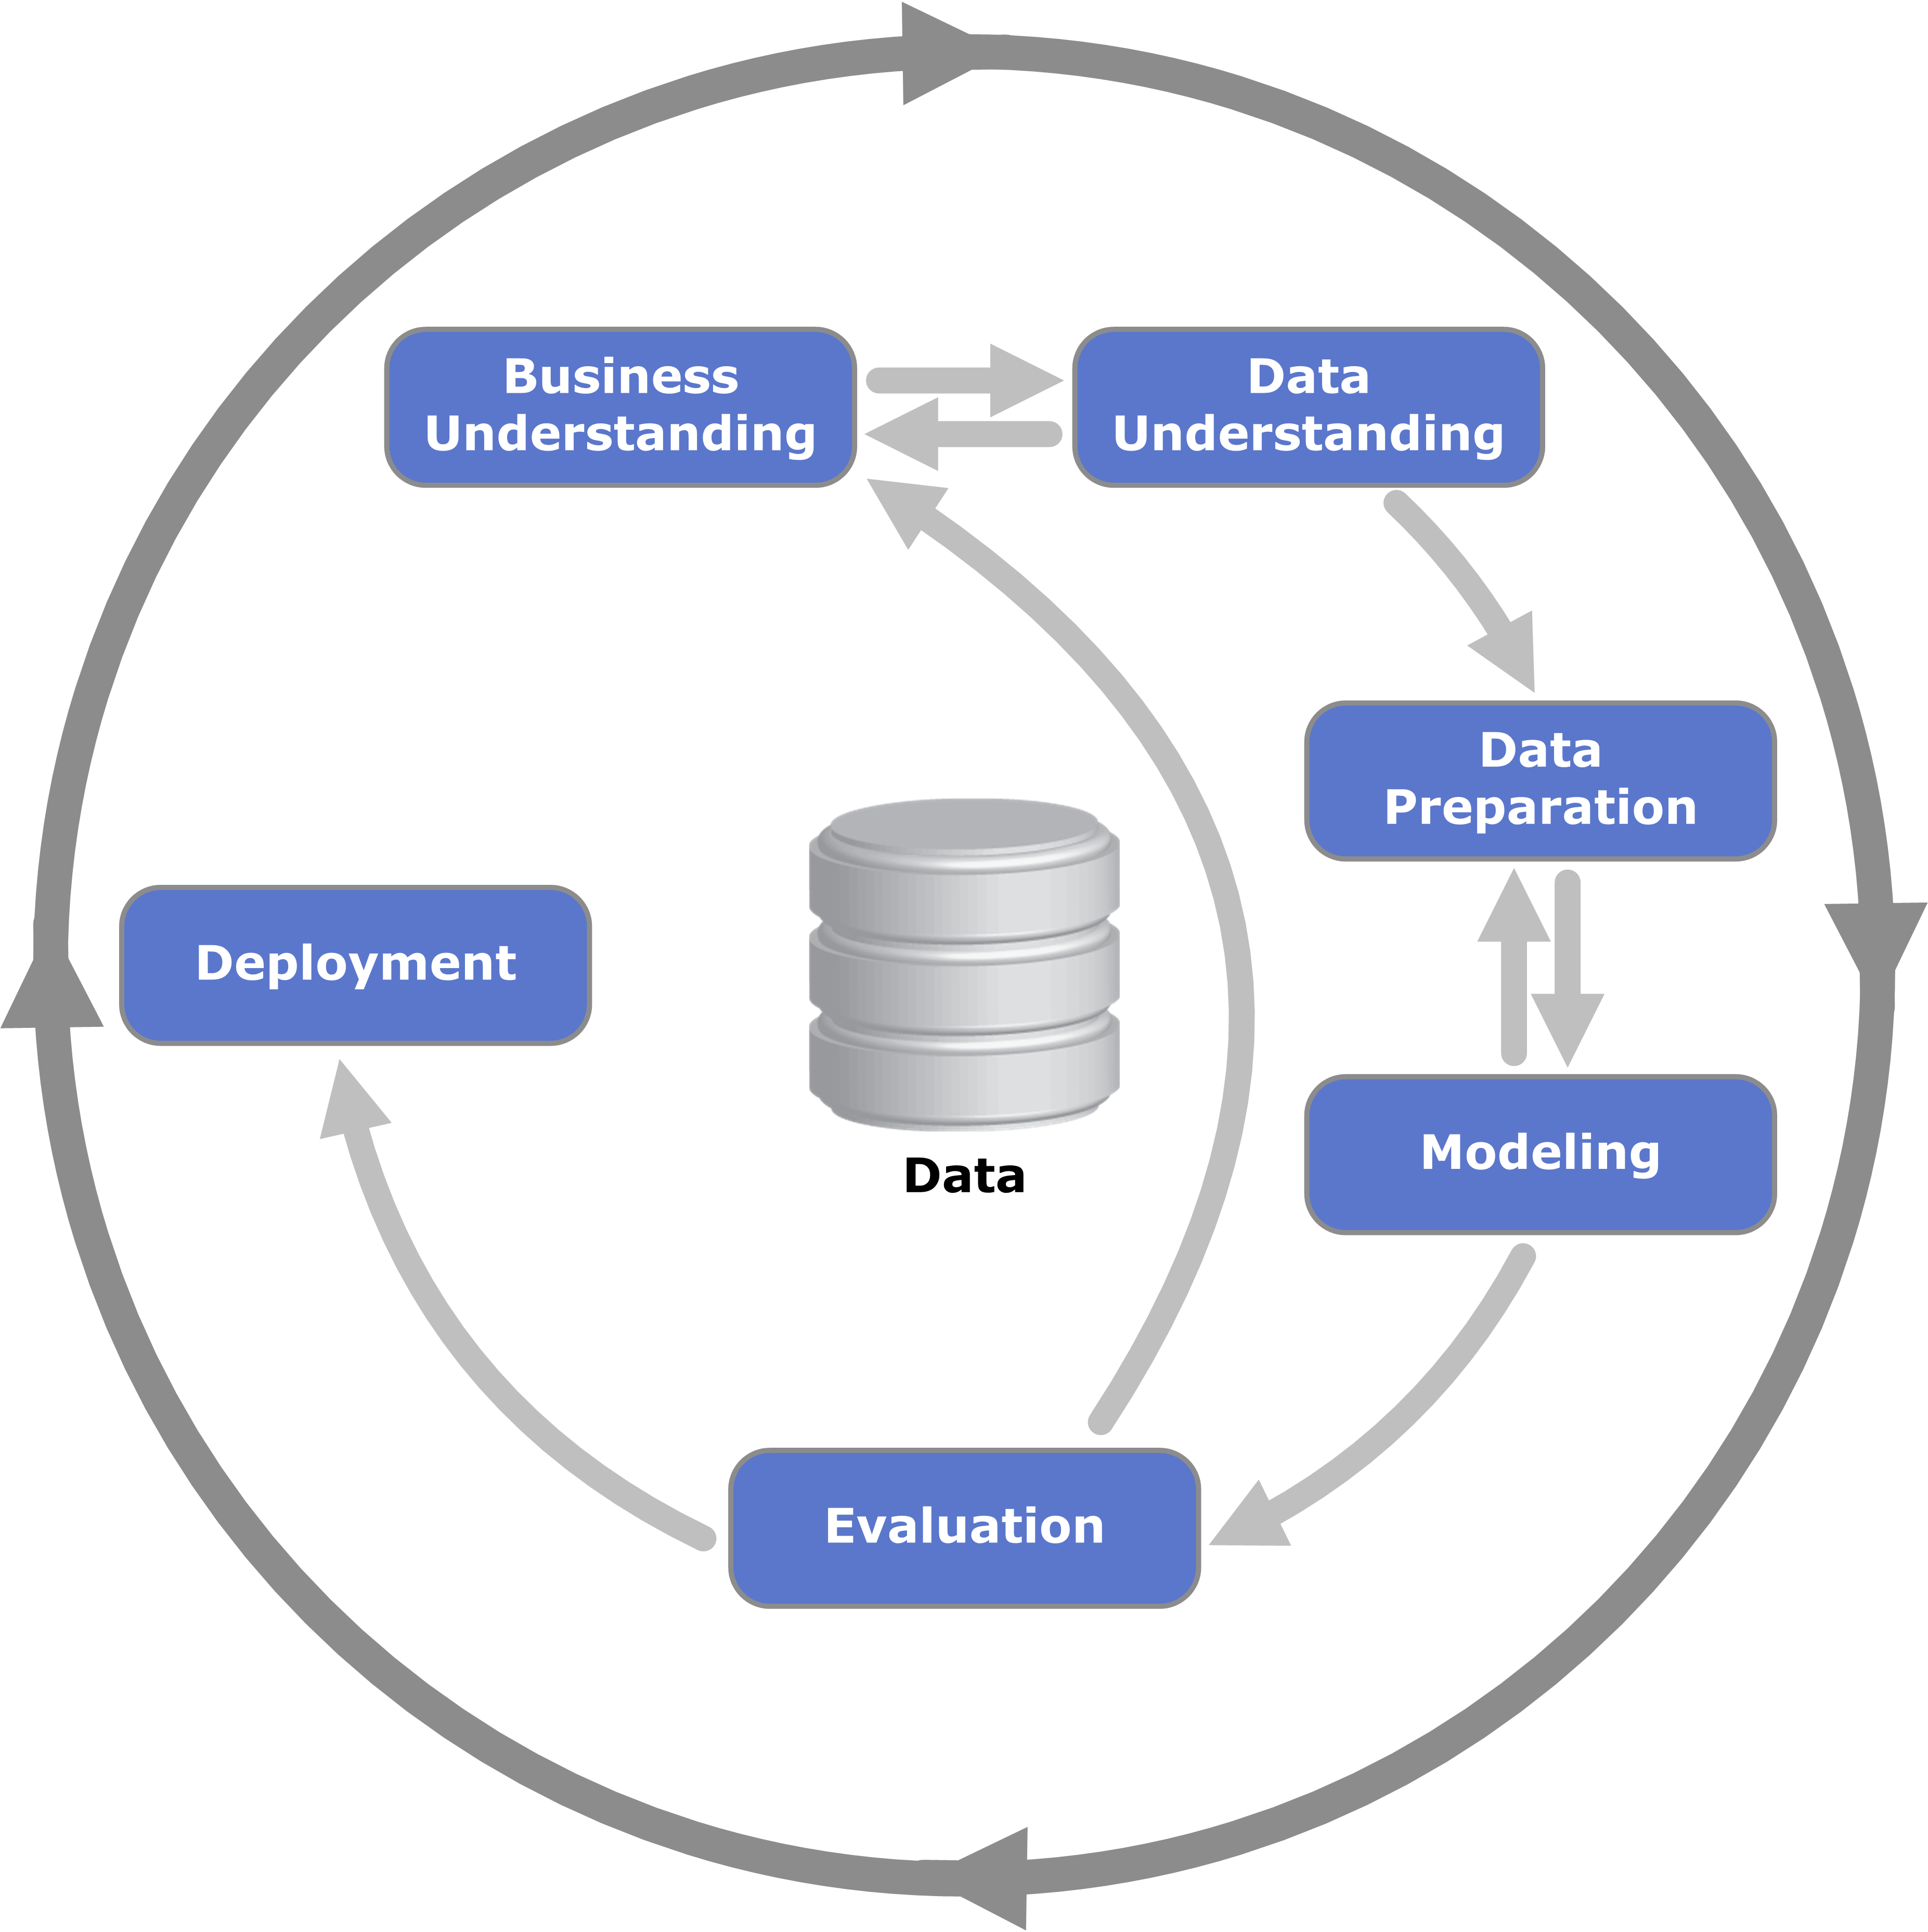

In [7]:
Image('../imgs/CRISP-DM_Process_Diagram.png' )
#source = https://commons.wikimedia.org/wiki/File:CRISP-DM_Process_Diagram.png

# 1.0 Data Description


## 1.1 Rename Columns

In [4]:
df1 = df_raw.copy()

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Converting cols to snakecase
snake_case = lambda x: inflection.underscore( x ) 
cols_new = list( map( snake_case, cols_old) )

# Renaming
df1.columns = cols_new

## 1.2 Data Dimensions

In [5]:
print( 'Number of Rows: {:,}'.format(df1.shape[0] ) )
print( 'Number of Cols: {}'.format(df1.shape[1] ) )

Number of Rows: 1,017,209
Number of Cols: 18


## 1.3 Data Types

In [6]:
df1['date'] = pd.to_datetime( df1['date'] ) #.dt.strftime('%Y-%m-%d') #.dt.strftime('#Y-#m-#d')
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 NA Check

In [7]:
df1.isna().sum()
df1.isna().sum()/df1.shape[0]

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## 1.5 NA Fillout

In [8]:
#competition_distance

#print('NA examples')
#print(df1[df1['competition_distance'].isna()].sample(5, random_state = 42) )
#df1[df1['competition_distance'].isna()].head(5)
#df1['competition_distance'].max() = 75860.0
df1['competition_distance'].fillna(value = 200000.0, inplace = True)

# we will set distance to a high number to indicate that the nearest competitor is considerably far away (much more than the max val)


In [9]:
# DATE NAs (maybe change to 0 in next CRISP cycle)

#competition_open_since_month
#print('NA examples')
#print(df1[df1['competition_open_since_month'].isna()])
#a = df1[df1['competition_open_since_month'].isna()]
#pd.to_datetime(df1['date'][5]).year #.strftime('%Y')
df1[ 'competition_open_since_month' ] = df1.apply( lambda s: s['date'].month 
   if math.isnan( s['competition_open_since_month'] ) 
   else  s['competition_open_since_month'] , axis = 1)
# replace NA with current date

#competition_open_since_year
df1[ 'competition_open_since_year' ] = df1.apply( lambda s: s['date'].year 
   if math.isnan( s['competition_open_since_year'] ) 
   else  s['competition_open_since_year'] , axis = 1)
# replace NA with current date

#promo2_since_week
#a = df1[ df1['promo2_since_week'].isna() & df1['promo2'] != 0 ]
#a = df1[ df1['promo2_since_week'].isna() ]
# there is no observation where promo2 != 0 where pormo2since is null, hence,
# if promo2since is NA there is no promo on going
df1[ 'promo2_since_week' ] = df1.apply( lambda s: s['date'].week 
   if math.isnan( s['promo2_since_week'] ) 
   else  s['promo2_since_week'] , axis = 1)
# replace NA with current date

#promo2_since_year
df1[ 'promo2_since_year' ] = df1.apply( lambda s: s['date'].year 
   if math.isnan( s['promo2_since_year'] ) 
   else  s['promo2_since_year'] , axis = 1)
# replace NA with current date

In [10]:
# promo_interval
# 0 for consecutive promo non participating stores

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1.apply( lambda s: s['date'].strftime('%b'), axis = 1 )

# promo2 active?
df1['is_promo'] = df1.apply( lambda s: 
    1 if (s['promo_interval'] !=0) and (s['month_map'] in s['promo_interval']) 
    else 0 , axis = 1)

df1.to_csv('./df1.csv', index = False)
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Changing Data Types


In [15]:
print(df1.dtypes)

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [29]:
# Dispersion stats
# min, max, range, mean, median, std, skew, curtosis,

num_att = df1.select_dtypes( include = ['int', 'float'])
cat_att = df1.select_dtypes( exclude = ['int', 'float', 'datetime'])

d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( stats.skew( num_att ) ).T
d8 = pd.DataFrame( stats.kurtosis(num_att) ).T
d7.columns = list(d6.columns)
d8.columns = list(d6.columns)

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = [ 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'curtosis' ]
desc

,min,max,range,mean,median,std,skew,curtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641459,1.778360
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598648,7.091732
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758042,1.090712
promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487837,-1.762015
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677839,0.815144
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242329,147.788979
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235647,124.070688


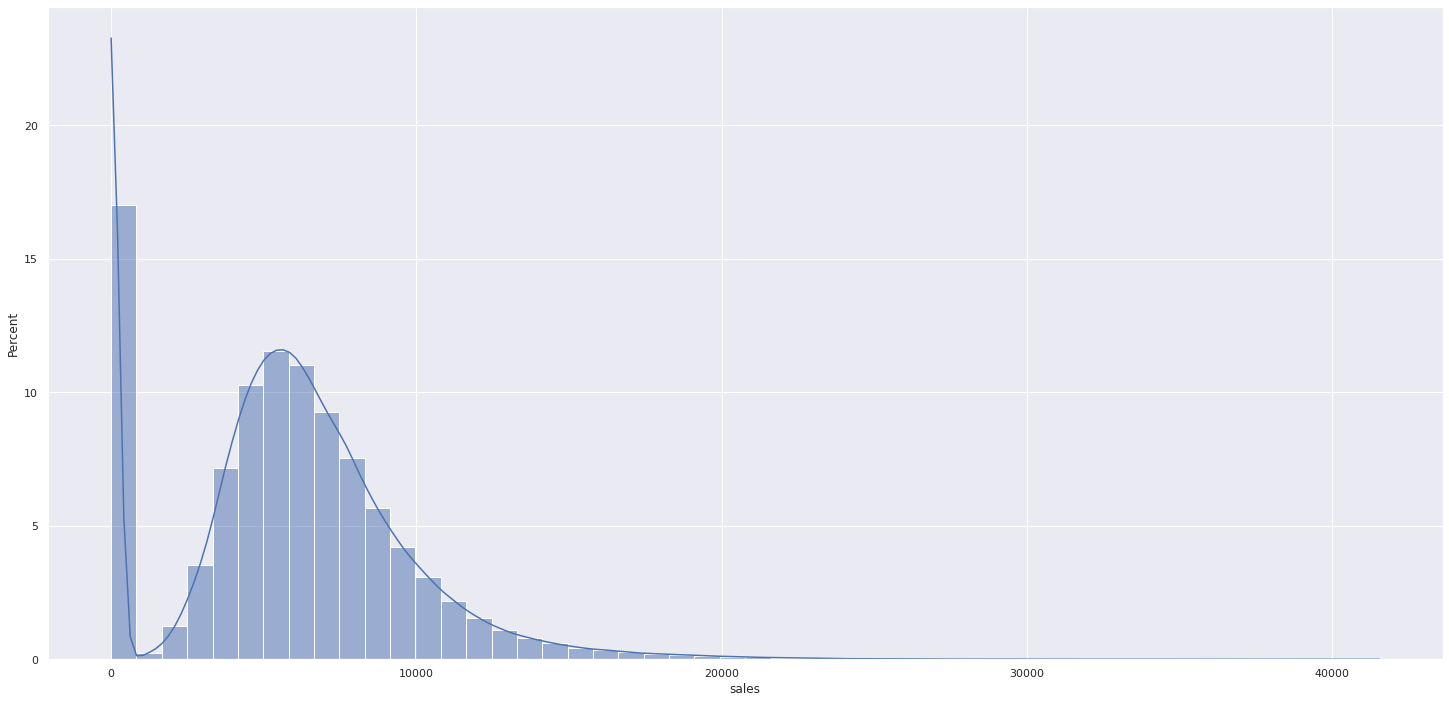

In [41]:
sns.histplot( df1['sales'], stat = 'percent', bins = 50, kde = True);

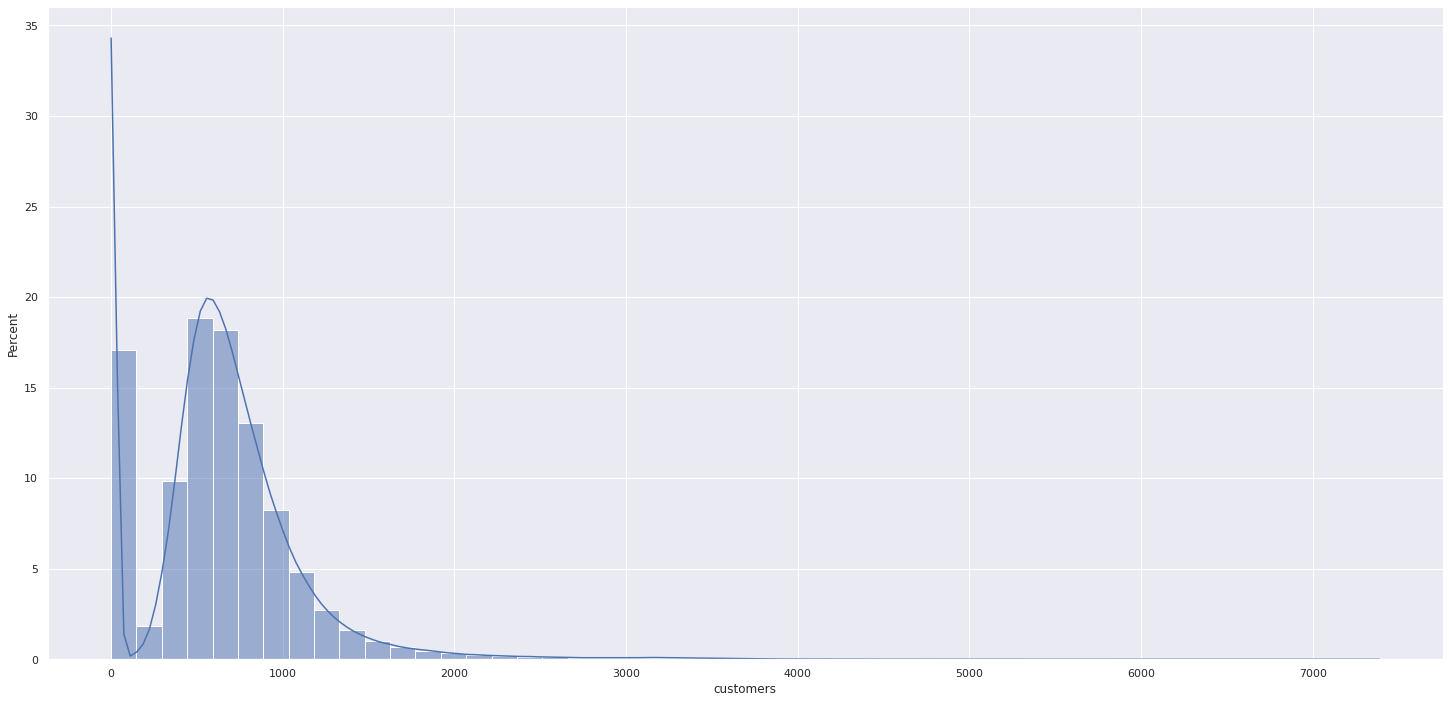

In [42]:
sns.histplot( df1['customers'], stat = 'percent', bins = 50, kde = True);

/home/humberto/anaconda3/envs/ross2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


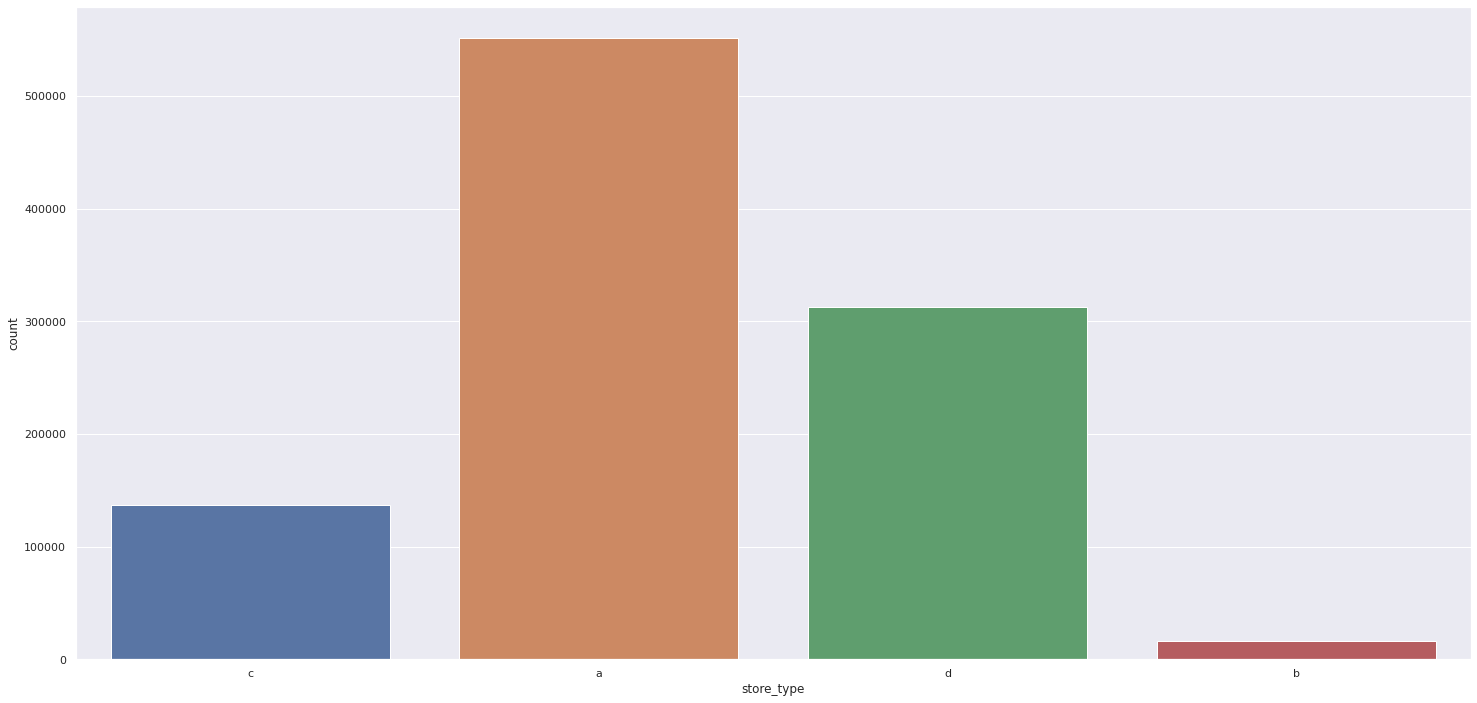

In [44]:
sns.countplot( df1['store_type'] );

### 1.7.2 Categorical Attributes

In [47]:
cat_att.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

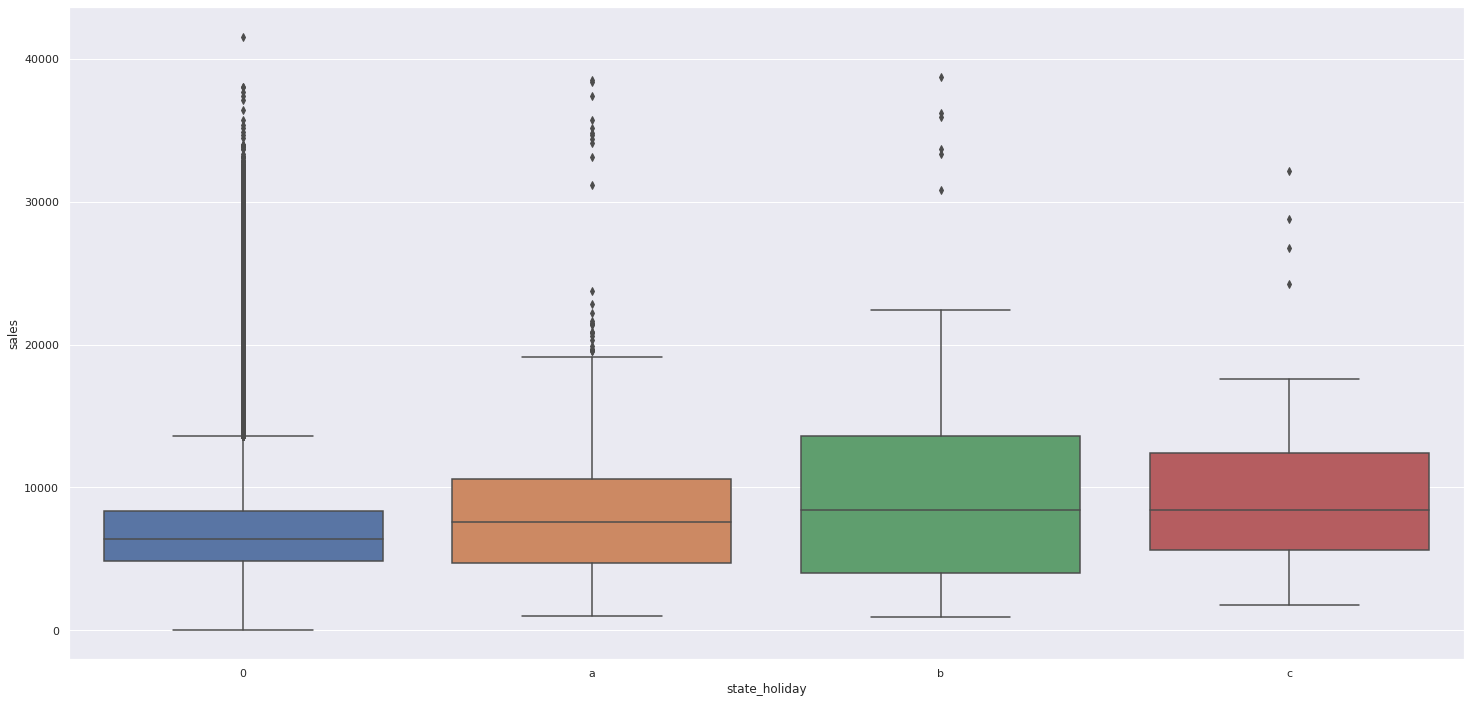

In [49]:
df_aux = df1.loc[ #(df1['state_holiday'] == '0' ) &
                  (df1['sales'] != 0 )]
#sns.boxplot( data = df_aux, x='day_of_week', y = 'sales')
#df1.state_holiday.value_counts()
sns.boxplot( data = df_aux, x='state_holiday', y = 'sales');

# 2.0 Feature Engineering

## 2.1 Sales Mind Map

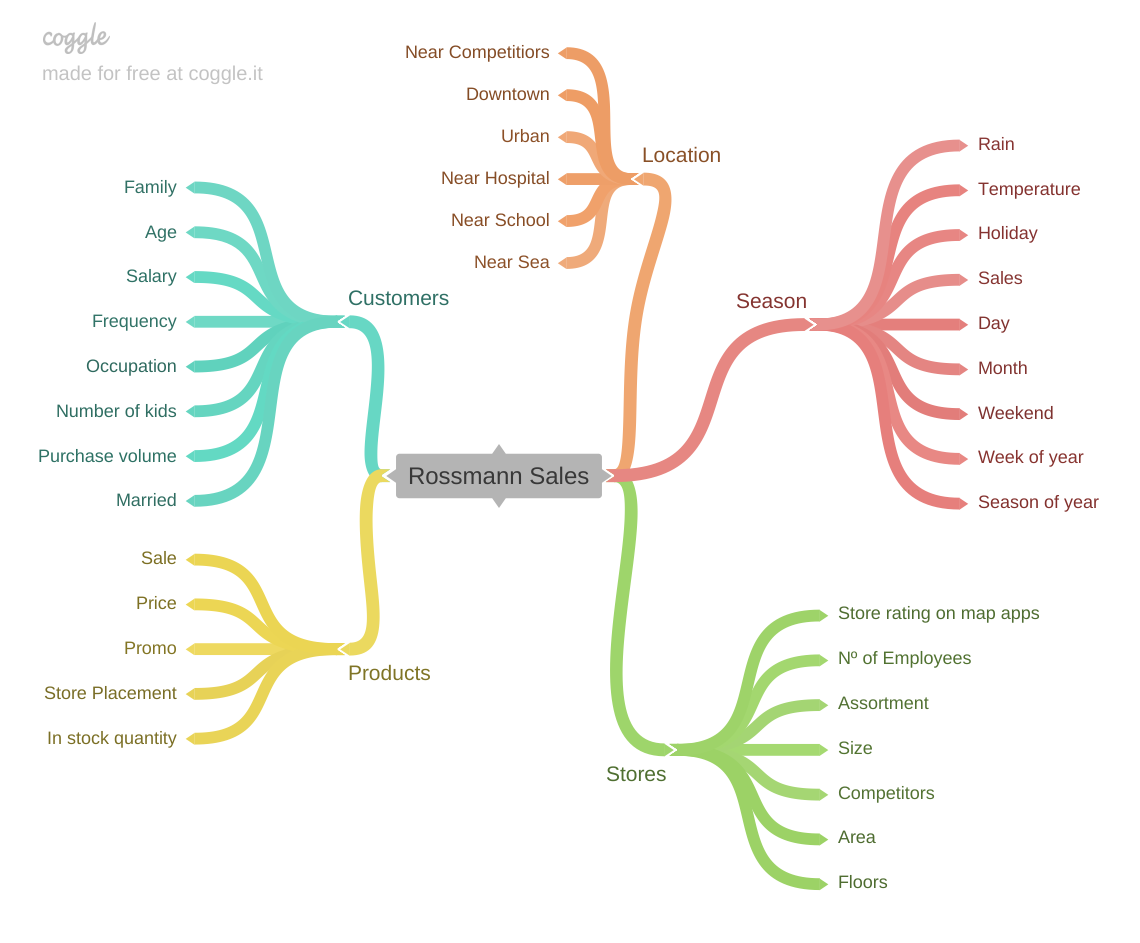

In [4]:
Image('../imgs/Rossmann_Sales.png')

## 2.2 Hypothesis List

### **Store:**
### - Stores with higher ratings on map apps should sell more
### - Stores with higher number of employees should sell more
### - Assortment impacts sales
### - Store size impacts sales
### - Stores with more floors should sell more
### - Stores with more competitors nearby should sell less
### - Stores near hospitals should sell more
### - Stores in downtown should sell more
### - Stores running promo should sell more

### **Time:**
### - Stores open during christmas should sell more
### - Sales decrease with time passage by as competitors settle nearby
### - Seasons impact sales
### - Day of week impact sales
### - Stores should sell more on weekends
### - Temperature impacts sales'
### - Weather impacts sales
### - Stores running extended promo should sell more
### - Stores should sell more in the second semester
### - Stores should sell more as years go by
### - Stores should sell less during school holidays

### **Products:**
### - Lower priced products sell more
### - Products with lower quantity in stock sell more
### - Products with higher discount should sell more
###

## 2.3 Selected Hypothesis:

### **H1:** Assortment impacts sales
### **H2:** Stores with more competitors nearby should sell less
### **H3:** Sales decrease with time passing by competitors settle nearby
### **H4:** Stores running promo should sell more
### **H5:** Stores with extended promo for longer periods should sell more
### **H6:** Stores running extended promo should sell more
### **H7:** Stores open during christmas should sell more than in other holidays
### **H8:** Stores should sell more as years go by
### **H9:** Stores should sell more in the second semester
### **H10:** Stores sell more on weekends
### **H11:** Stores sell less during school holidays

## 2.4 Feature Engineering

In [ ]:
df2 = df1.copy()

In [17]:
# Extracting date time features for model usage
# year 
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week'] = df2['date'].dt.week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
         year = x['competition_open_since_year'], 
         month = x['competition_open_since_month'],
         day = 1), axis = 1 )

# competition Time in months
df2['competition_time_months'] = ( (df2.date - df2['competition_since'])/30 ).apply( lambda x: x.days ).astype(int)

# time since promo2 started in weeks
df2['promo2_in_weeks'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo2_in_weeks'] = df2['promo2_in_weeks'].apply( lambda x: datetime.datetime.strptime(x, "%Y-%W-%w") ) - datetime.timedelta( days=7 )
df2['promo2_in_weeks'] = ( ( df2['date'] - df2['promo2_in_weeks'] )/7 ).apply( lambda x: x.days).astype(int)

# assortment mapping
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# holiday mapping
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'regular_day' if x== '0'
       else 'public_holiday' if x == 'a'
       else 'easter_holiday' if x == 'b'
       else 'christmas' )

# df2['state_holiday'].value_counts()
df2.to_csv( './df2.csv', index = False)
df2.columns

/home/humberto/anaconda3/envs/ross2/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week', 'year_week', 'competition_since',
       'competition_time_months', 'promo2_in_weeks'],
      dtype='object')

In [20]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week,year_week,competition_since,competition_time_months,promo2_in_weeks
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,0


# 3.0 Variable Selection

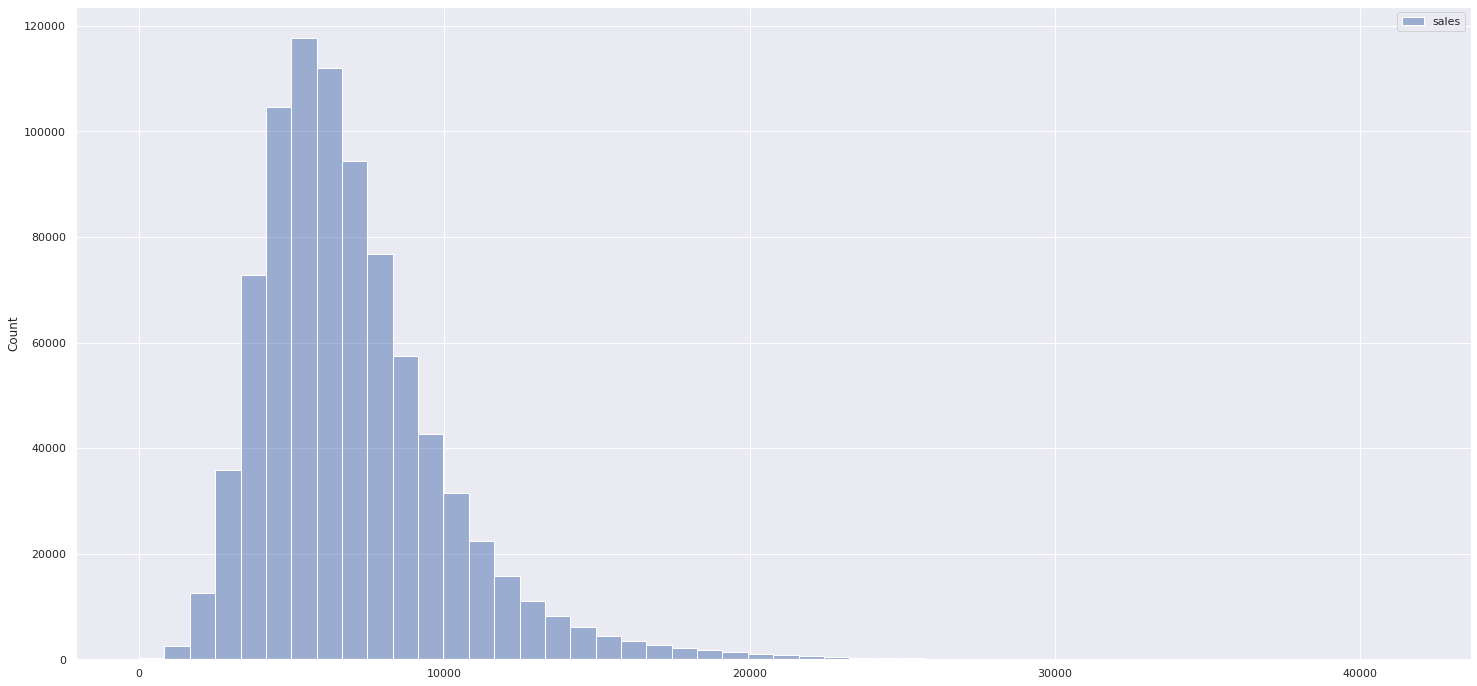

In [ ]:
df3 = df2.copy()
#df3 = pd.read_csv('./df2.csv', low_memory= False ) # date_parser=['date'],

# sales with store open
sns.histplot( df3[df3['open'] != 0 ][['sales']], bins = 50 );

In [ ]:
df3.loc[ (df3['open']!= 0) & (df3['sales'] < 100) ].shape
# very few observations with store open and sales == 0

(55, 28)

In [ ]:
# Removing observations where store is closed and/or sales == 0
df3 = df3.loc[ (df3['open']!= 0) & (df3['sales'] >0) ].copy()

# Removing customers (won't have that for prediction since it's a future information) and other variables that won't be used
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map']
df3.drop( cols_drop, axis = 1, inplace = True)
df3.to_csv( './df3.csv', index = False)


# 4.0 Exploratory Data Analysis

In [ ]:
#df4 = df3.copy()
df4 = pd.read_csv('./df3.csv', low_memory = False)

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

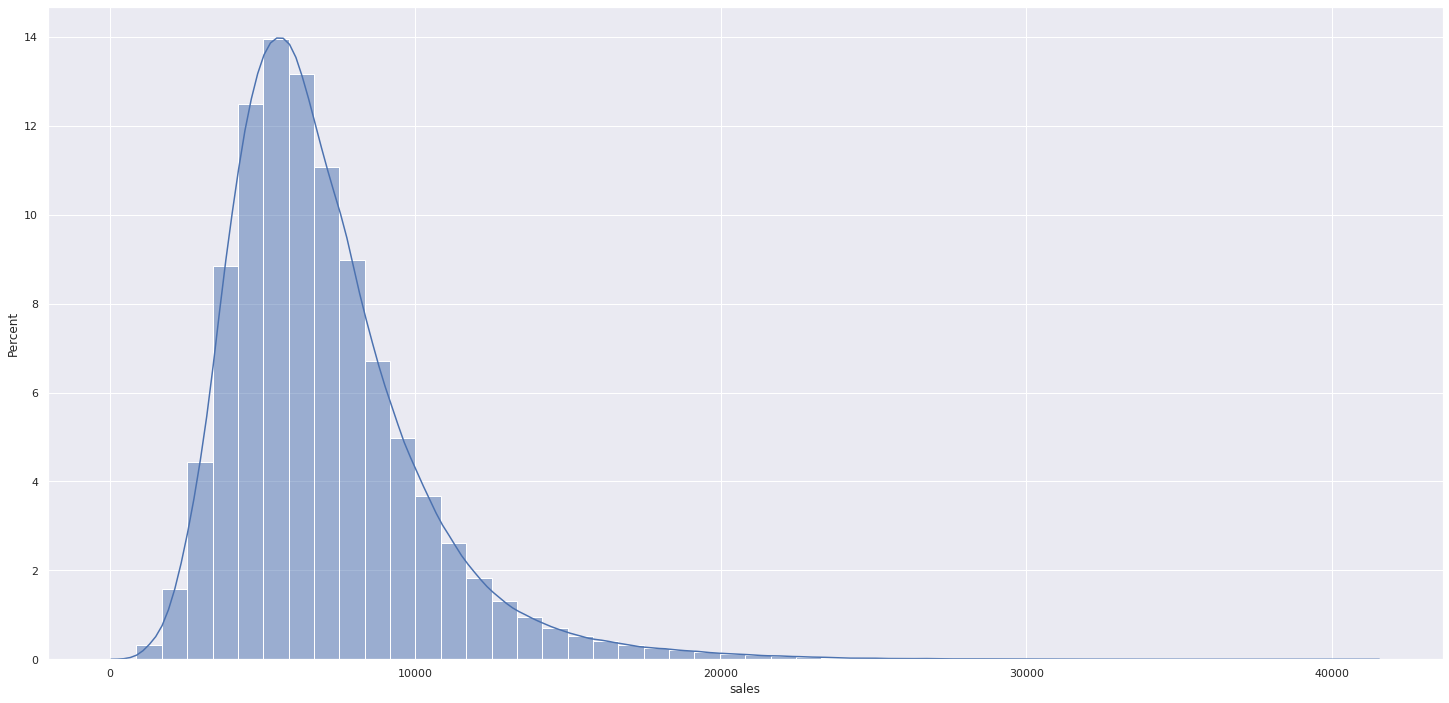

In [ ]:
#sns.distplot( df4['sales'] ); #, kde = False # to remove the line
sns.histplot( df4['sales'], kde = True, stat = 'percent', bins = 50 ); #, kde = False # to remove the line


### 4.1.2 Numerical Variables

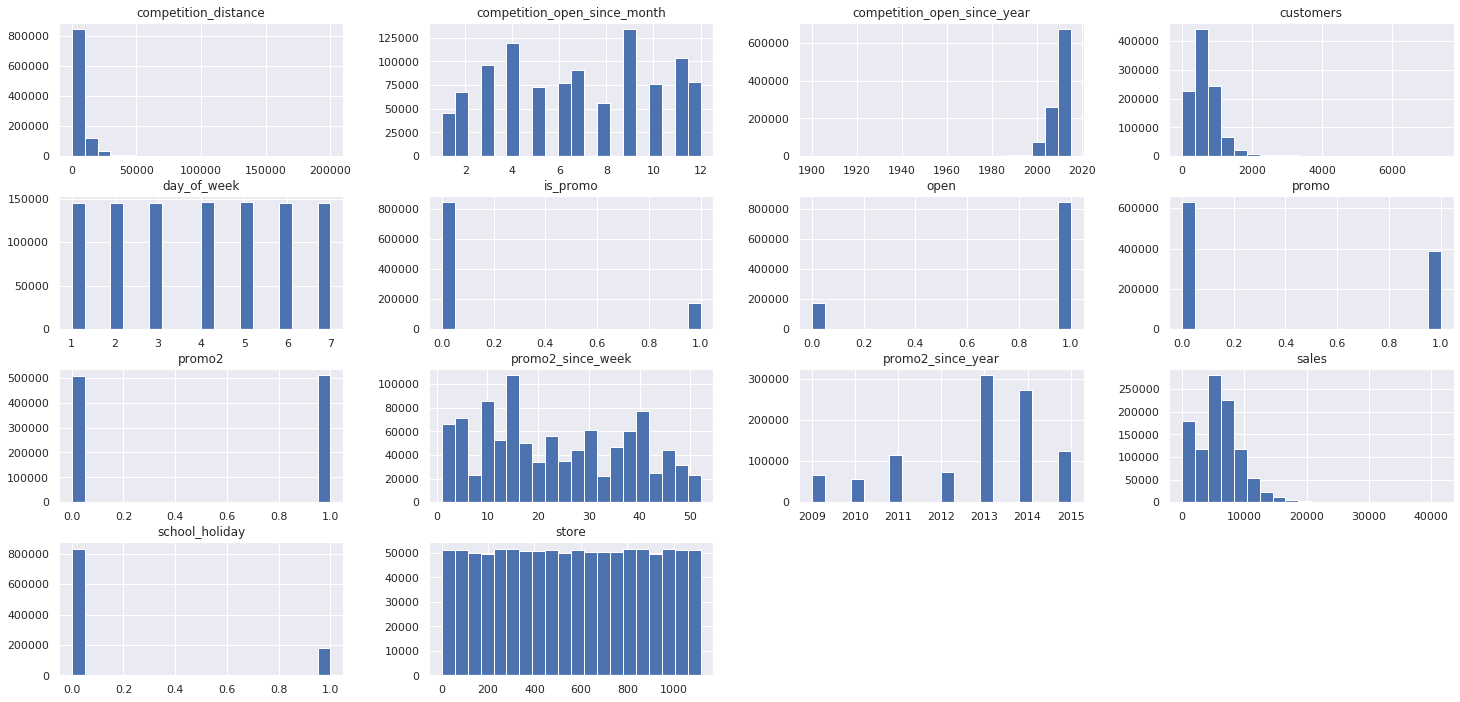

In [ ]:
num_att.hist( bins = 20 );

#### - Competition Distance: Most competitor stores are located nearby, in fact, less than 5 km away
#### - Competition Since Month: Months 4 and 9 is when the highest amount of competitors opened their stores
#### - Competition Since Year: Competition has increased considerably in last years (or at least, our ability to measure competition)
#### - Customers: In general most sales happen with 1000 customers, sometimes with up to 2000 customers in store
#### - Days of week: We have approximately the same amount of sale records for each day of the week
#### - Is Promo: Most of the records are from non promotional days
#### - Open: Most of records are from days when stores are open
#### - Promo: Near 60% of the records are from non promotional months
#### - Promo2 : Half of stores do  participate in consecutive promotions
#### - Sales: The majority of sales are up to $20k

### 4.1.3 Categorical Variables

In [ ]:
cat_att.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

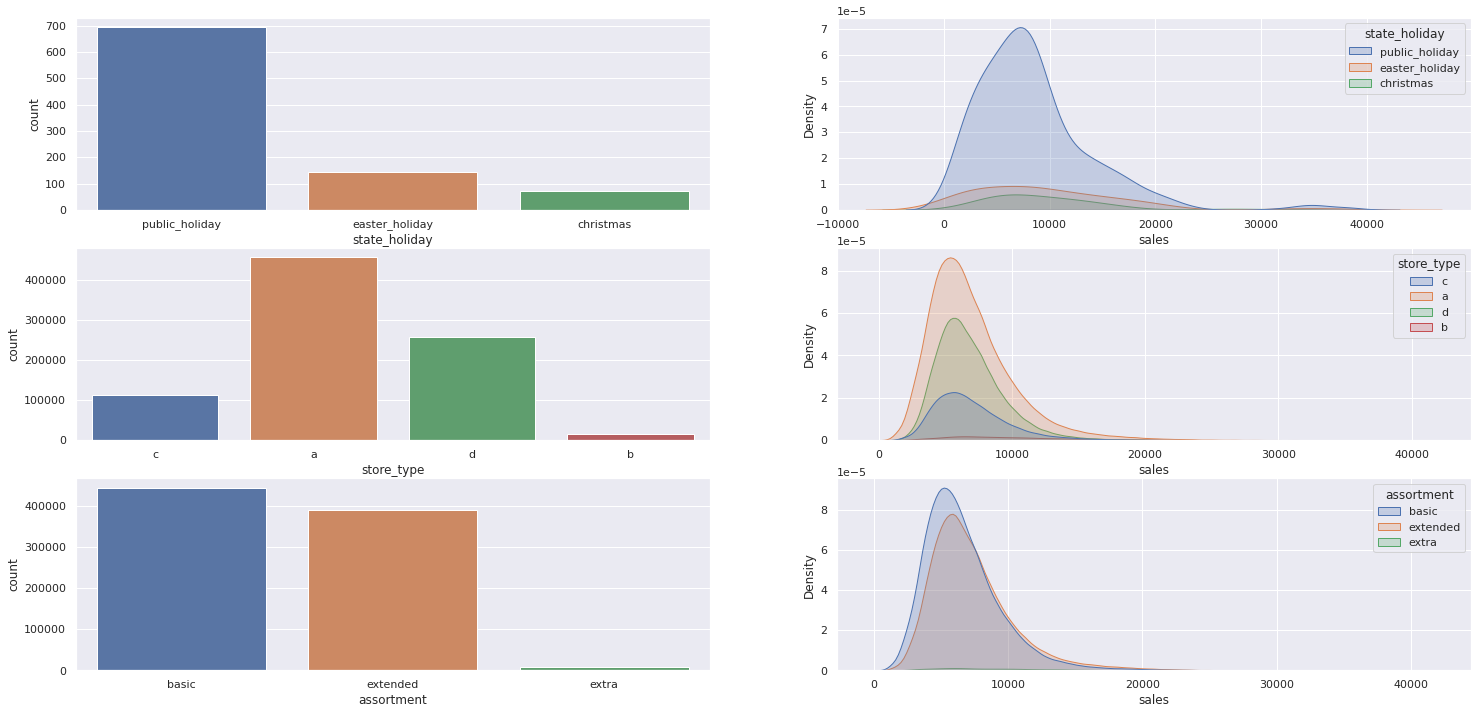

In [ ]:
# state_holiday
aux = df4.loc[ df4['state_holiday'] != 'regular_day' ]
plt.subplot( 3, 2, 1 )
sns.countplot( x = 'state_holiday', data = aux )

plt.subplot( 3, 2, 2 )
sns.kdeplot( x = 'sales', hue = 'state_holiday', data = aux, shade = True)

# store type
plt.subplot( 3, 2, 3)
sns.countplot( x ='store_type', data = df4)

plt.subplot( 3, 2, 4)
sns.kdeplot( x = 'sales', hue = 'store_type', data = df4, shade = True)

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( x = 'assortment', data = df4)

plt.subplot( 3, 2, 6)
sns.kdeplot( x = 'sales', hue = 'assortment', shade = True, data = df4);

## 4.2 Bivariate Analysis

### **H1.** Store type and Assortment impacts sales:
**TRUE**: Among all store types, "b" type is the best performant on average.

With respect to assortment, "extended" is the top selller.

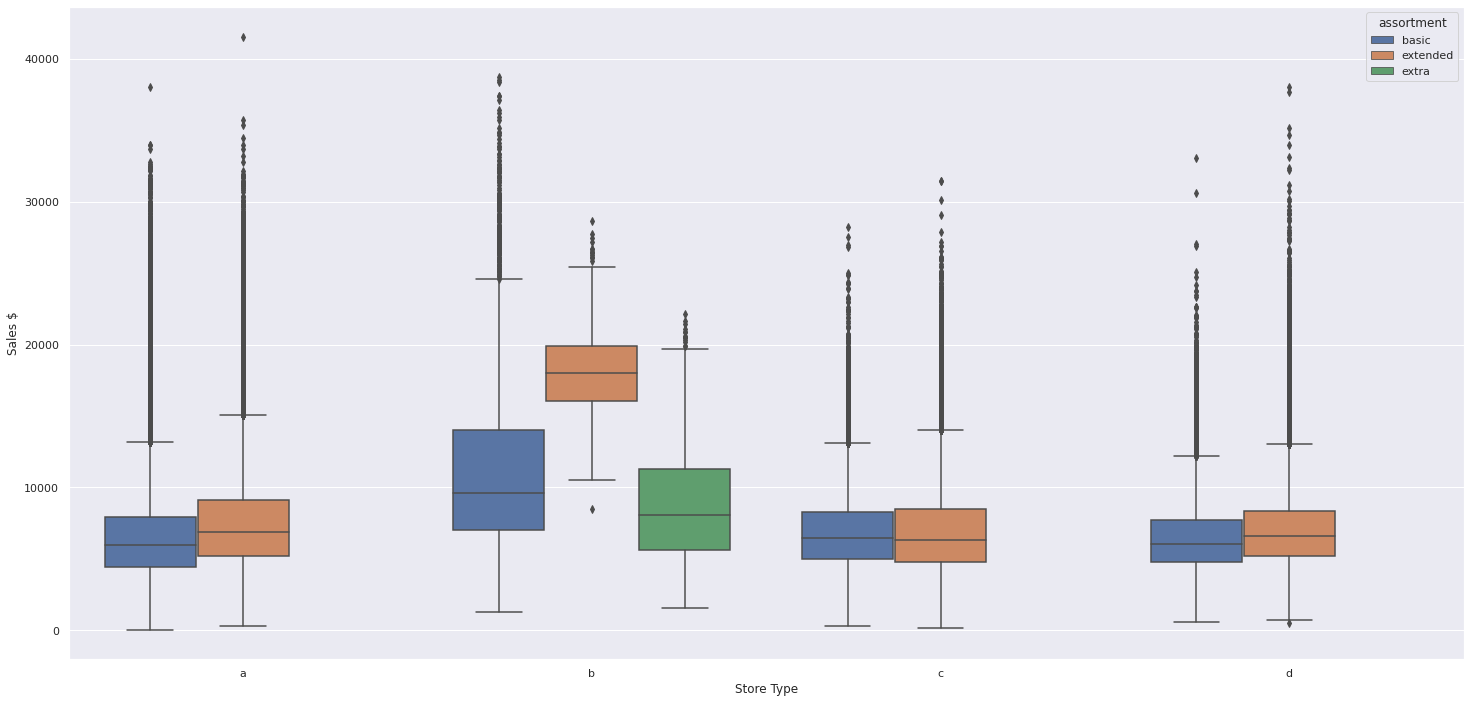

In [ ]:
aux = df4[[ 'sales', 'store_type', 'assortment' ]].copy()
sns.boxplot( x = 'store_type', y = 'sales', hue = 'assortment', data = aux, order = ['a', 'b', 'c', 'd'] )
plt.ylabel('Sales $')
plt.xlabel( 'Store Type');

In [ ]:
aux2 = pd.read_csv('../data/store.csv', low_memory= False)
aux2[['StoreType', 'Assortment']].groupby('StoreType').count().reset_index()

,StoreType,Assortment
0,a,602
1,b,17
2,c,148
3,d,348


### **H2.** Stores with more competitors nearby sell less
**FALSE** Stores with more competitors nearby sell more

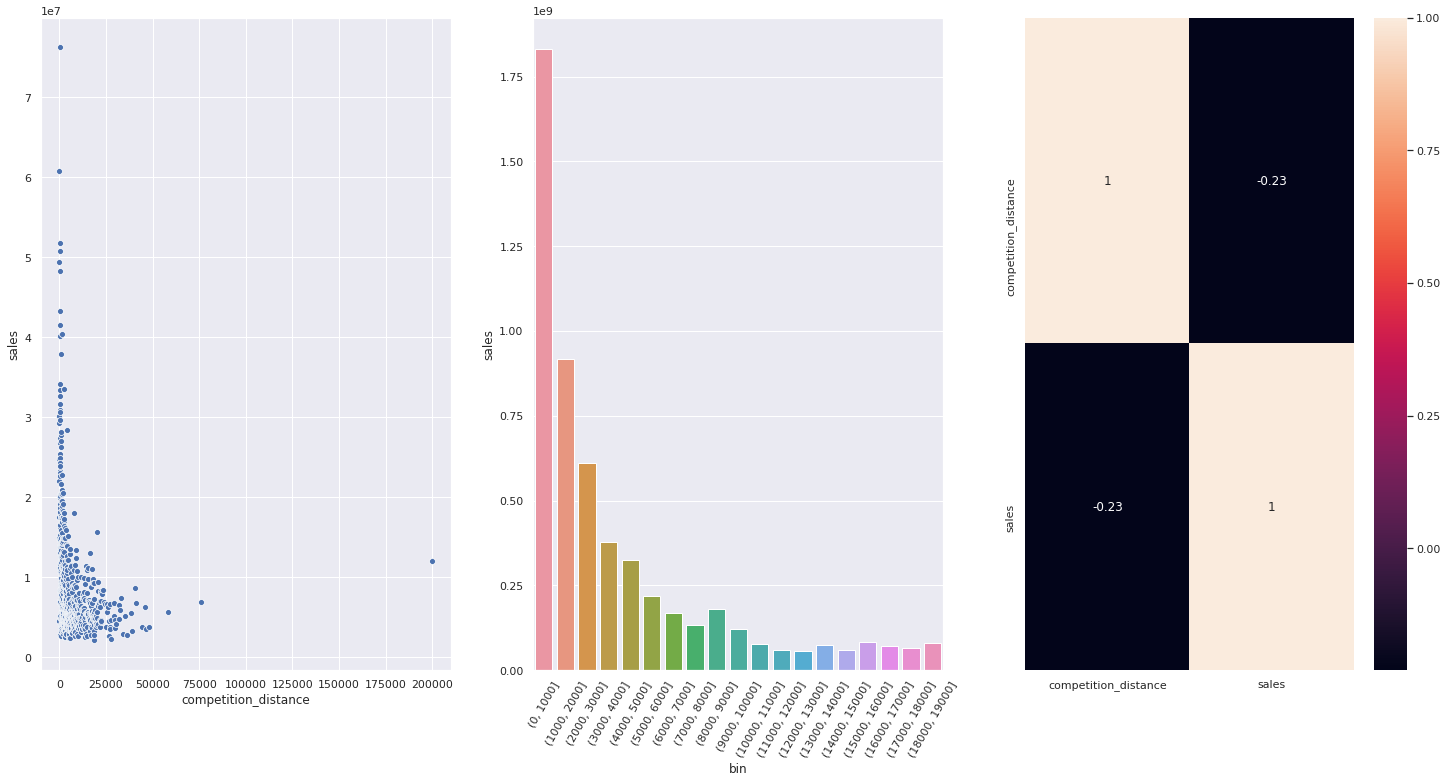

In [ ]:
aux1 = df4[[ 'competition_distance', 'sales' ]].copy().groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

bins = np.arange( 0, 20000, 1000)
aux1['bin'] = pd.cut( aux1['competition_distance'], bins )

aux2 = aux1.groupby('bin').sum().reset_index()
plt.subplot( 1, 3 ,2 )
sns.barplot( aux2['bin'], aux2['sales'] )
plt.xticks( rotation = 60)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True, cmap = 'vlag' );

### **H3.** Sales decrease with time passing by competitors settle nearby
**TRUE** Stores do sell less as competitors settle nearby

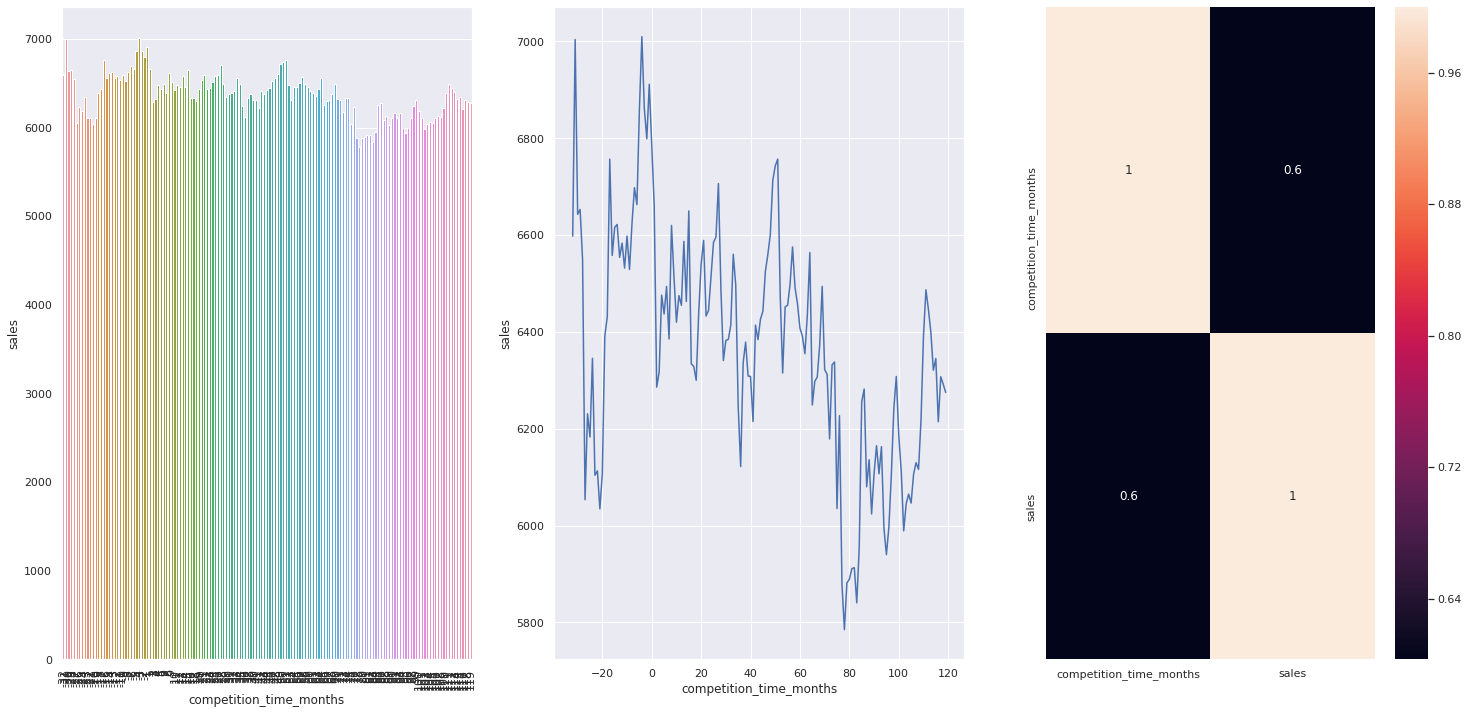

In [ ]:
aux1 = df4[[ 'competition_time_months', 'sales' ]].copy().groupby( 'competition_time_months' ).sum().reset_index()

aux2 = aux1[ (aux1['competition_time_months'] < 120) & ( aux1['competition_time_months'] != 0 ) ]
plt.subplot( 1, 3, 1)
sns.barplot( x = 'competition_time_months', y = 'sales', data = aux2 );
plt.xticks( rotation = 90);

plt.subplot( 1, 3, 2)
sns.lineplot( x = 'competition_time_months', y = 'sales', data = aux2  );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( 'pearson'), annot = True , cmap = 'vlag');

### **H4.** Stores running promo should sell more
**TRUE** On average stores tend to sell more in promo.

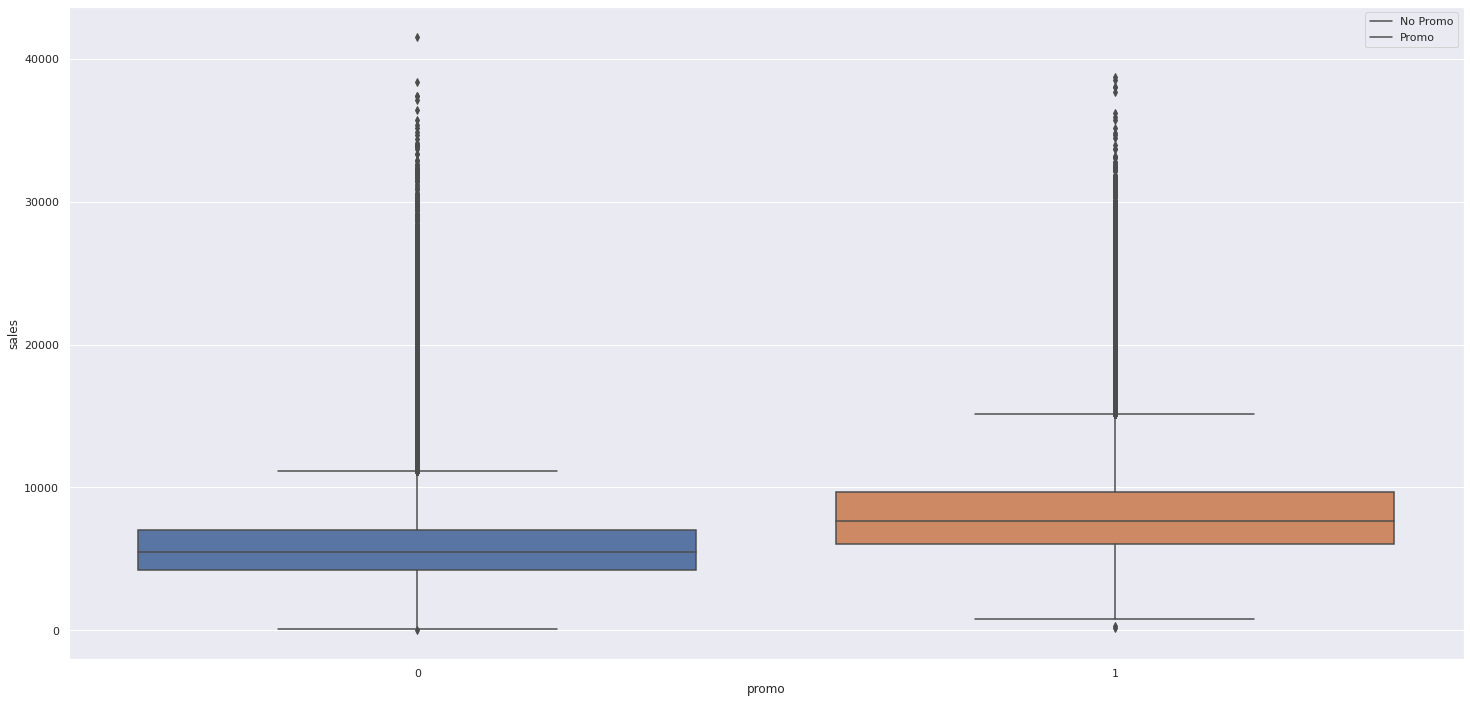

In [ ]:
aux1 = df4[[ 'sales', 'promo']]#.groupby('promo').sum().reset_index()
ax = sns.boxplot( x = 'promo', y = 'sales', data = aux1 );
ax.legend(['No Promo', 'Promo']);


### **H5.** Stores with extended promo for longer periods should sell more
**FALSE** After around 100 to 200 weeks of consecutive promo sales start to decrease

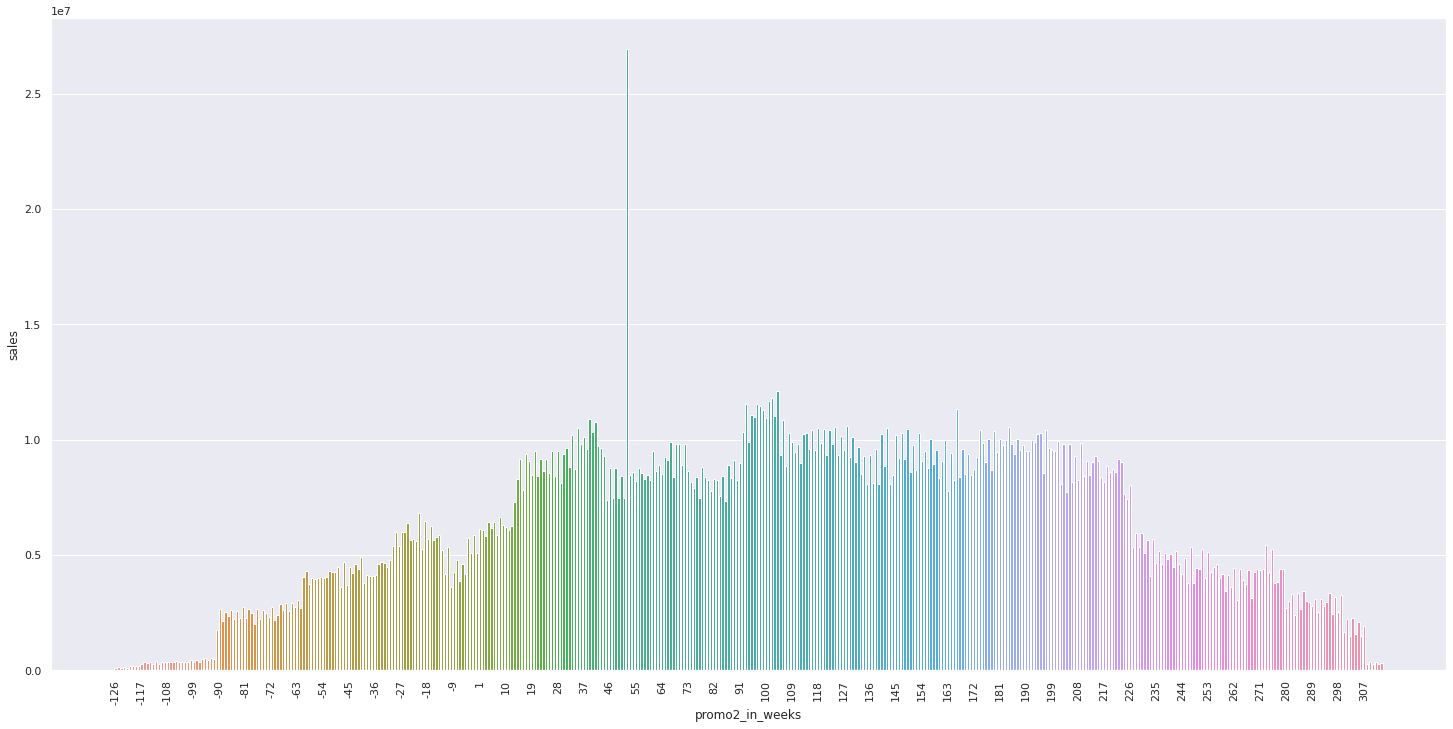

In [ ]:
aux1 = df4[[ 'promo2_in_weeks', 'sales']].copy().groupby( 'promo2_in_weeks').sum().reset_index()

sns.barplot( x = 'promo2_in_weeks', y = 'sales', data = aux2);
plt.xticks( rotation = 90);
plt.locator_params( axis = 'x', nbins = 50)

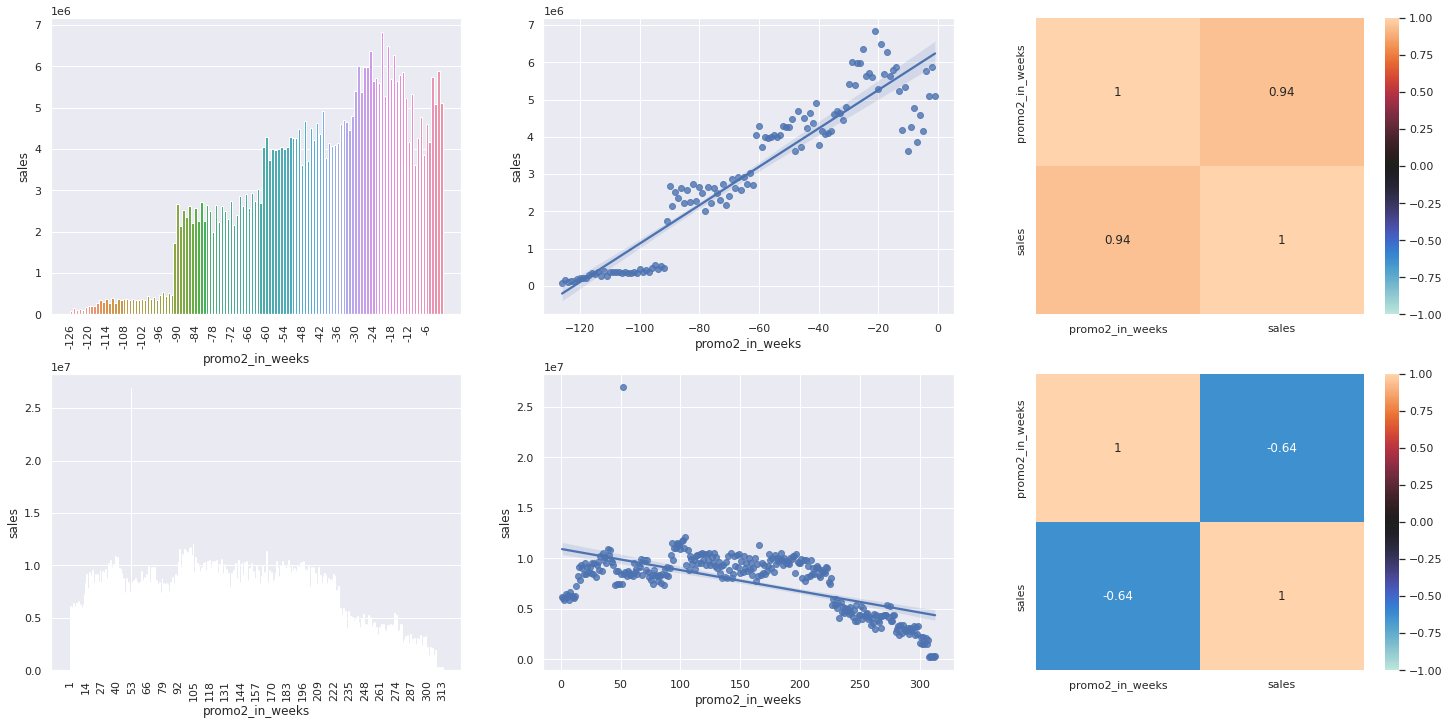

In [ ]:
#promo2_in_weeks
aux1 = df4[[ 'promo2_in_weeks', 'sales']].copy().groupby( 'promo2_in_weeks').sum().reset_index()
aux2 = aux1.loc[ aux1['promo2_in_weeks'] < 0].copy() #data before promo2 starts
aux3 = aux1.loc[ aux1['promo2_in_weeks'] > 0].copy() #data after promo2 starts

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
sns.barplot( x = 'promo2_in_weeks', y = 'sales', data = aux2);
plt.xticks( rotation = 90);
plt.locator_params( axis = 'x', nbins = 25)

plt.subplot( grid[0,1] )
sns.regplot( x = 'promo2_in_weeks', y = 'sales', data = aux2);

plt.subplot( grid[1,0] )
sns.barplot( x = 'promo2_in_weeks', y = 'sales', data = aux3);
plt.xticks( rotation = 90);
plt.locator_params( axis = 'x', nbins = 25)

plt.subplot( grid[1,1] )
sns.regplot( x = 'promo2_in_weeks', y = 'sales', data = aux3);

plt.subplot( grid[0,2] )
sns.heatmap( aux2.corr( method = 'pearson') , annot= True, vmin = -1, vmax = 1, cmap = 'icefire');

plt.subplot( grid[1,2] )
sns.heatmap( aux3.corr( method = 'pearson') , annot= True, vmin = -1, vmax = 1, cmap = 'icefire');


### **H6.** Stores running extended promo should sell more
**FALSE** Stores running extended promo sell less than thouse running only traditional promo

In [ ]:
aux = df4[['promo', 'promo2', 'sales']].copy().groupby( ['promo','promo2'] ).mean().reset_index()
aux.sort_values( 'sales', ascending= False)


,promo,promo2,sales
2,1,0,8618.452062
3,1,1,7836.672987
0,0,0,6328.187633
1,0,1,5529.566684


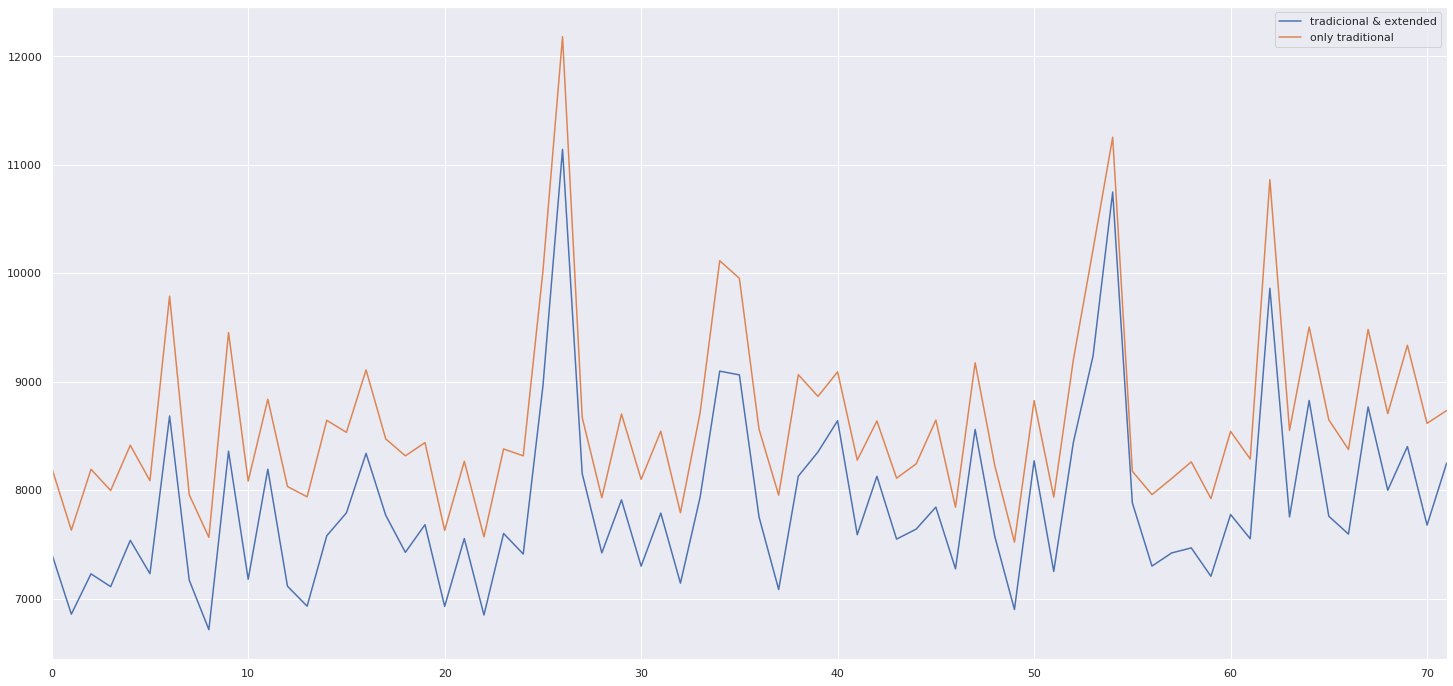

In [ ]:
#store participates in both promos
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1)][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()

#store participates only in normal promo
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] != 1)][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
a = aux2.plot( ax = ax )

ax.legend(labels = ['tradicional & extended', 'only traditional']);


### **H7.** Stores open during christmas should sell more than during other holidays
**FALSE** Stores open during easter holiday sell more than in christmas. 

Though it is important to note that sales average is higher in holidays than in normal days

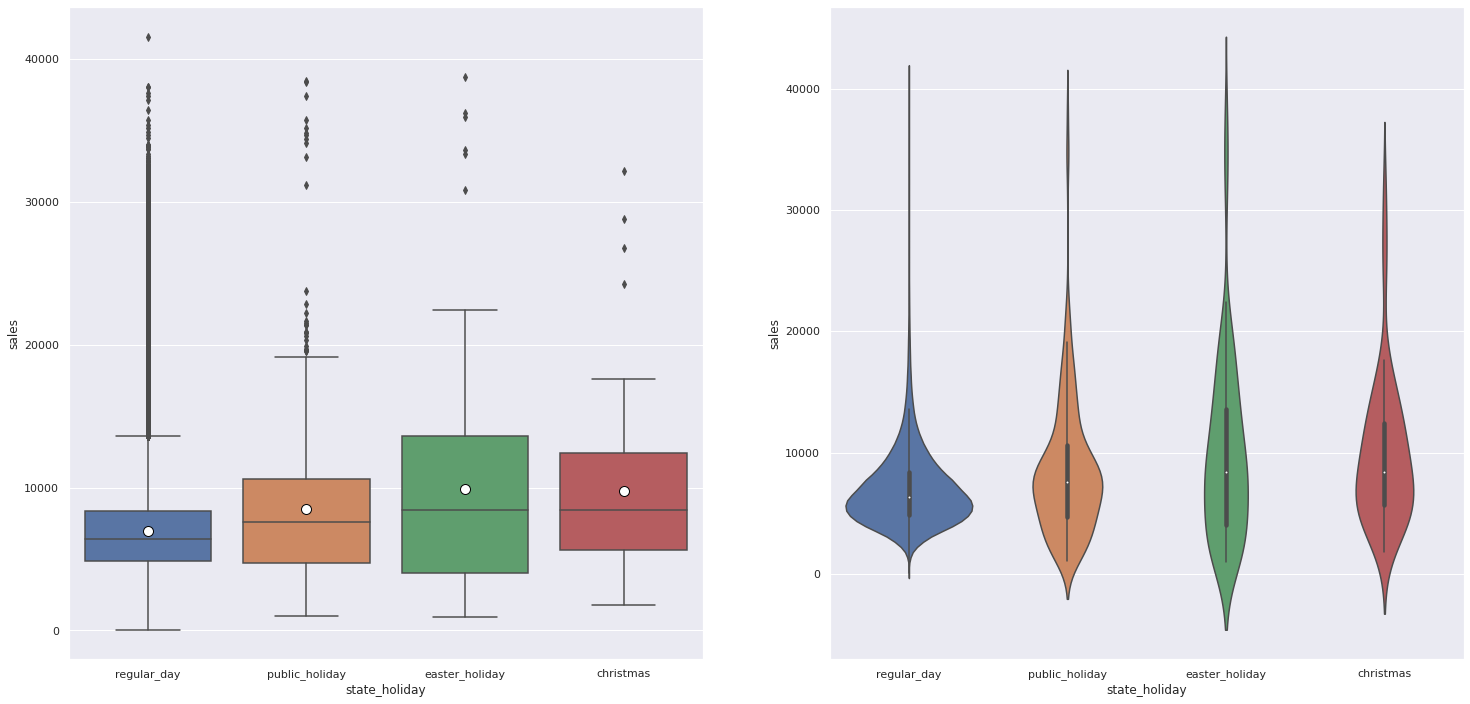

In [ ]:
aux = df4[['sales','state_holiday']] 
plt.subplot( 1, 2, 1)
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux,  showmeans = True, 
                        meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"} );

plt.subplot( 1, 2, 2)
sns.violinplot( x = 'state_holiday', y = 'sales', data = aux);

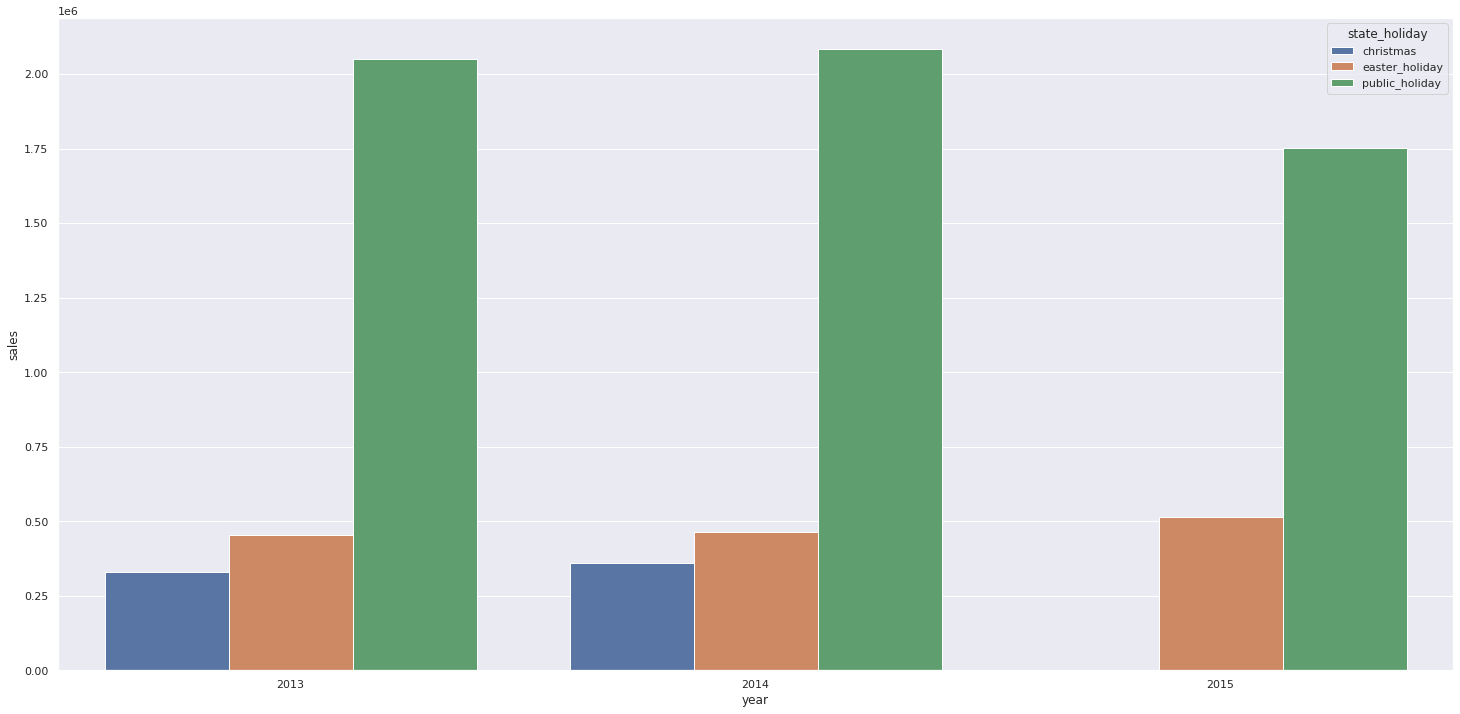

In [ ]:
# Total Sales
aux = df4[ df4['state_holiday'] != 'regular_day' ][['sales','state_holiday','year']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y = 'sales', hue = 'state_holiday',  data = aux);

### **H8.** Stores should sell more as years go by
**FALSE** Total sales decreased from 2013 to 2014, while the average of daily sales remain about the same. 

With respect to 2015 nothing can be affirmed, since the year is not yet consolidate in the database (we only have data up to july)

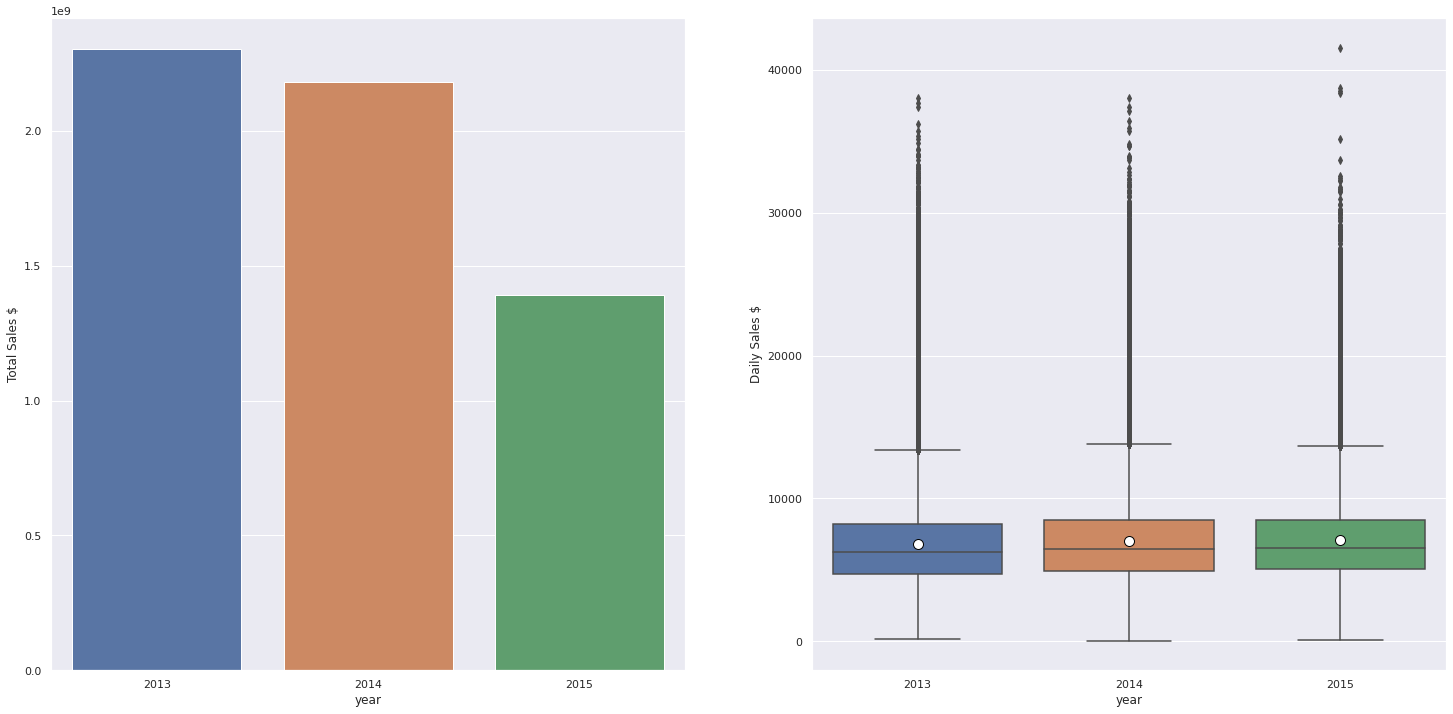

In [ ]:
aux1 = df4[['year','sales']].copy().groupby('year').sum().reset_index()
plt.subplot(1,2,1)
ax = sns.barplot( x = 'year', y = 'sales', data = aux1)
plt.ylabel('Total Sales $')


aux2 = df4[['year','sales']].copy()
plt.subplot(1,2,2)
sns.boxplot( x = 'year', y = 'sales', data = aux2, showmeans = True,
                        meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"} );
plt.ylabel('Daily Sales $');


In [ ]:
aux = df4[['year','sales']].copy().groupby('year').sum().reset_index()
#aux.T
df4[['year','month']].loc[ df4['year'] == 2015 ].max()

year     2015
month       7
dtype: int64

### **H9.** Stores should sell more in the second semester
**FALSE** Sales were higher in the second semester of 2013 and lower in the second semester of 2014. 2015 is not consolidated yet, so nothing can be affirmed.

We may see however that daily sales increase in the months 11th and 12th, possibly due to the holidays.

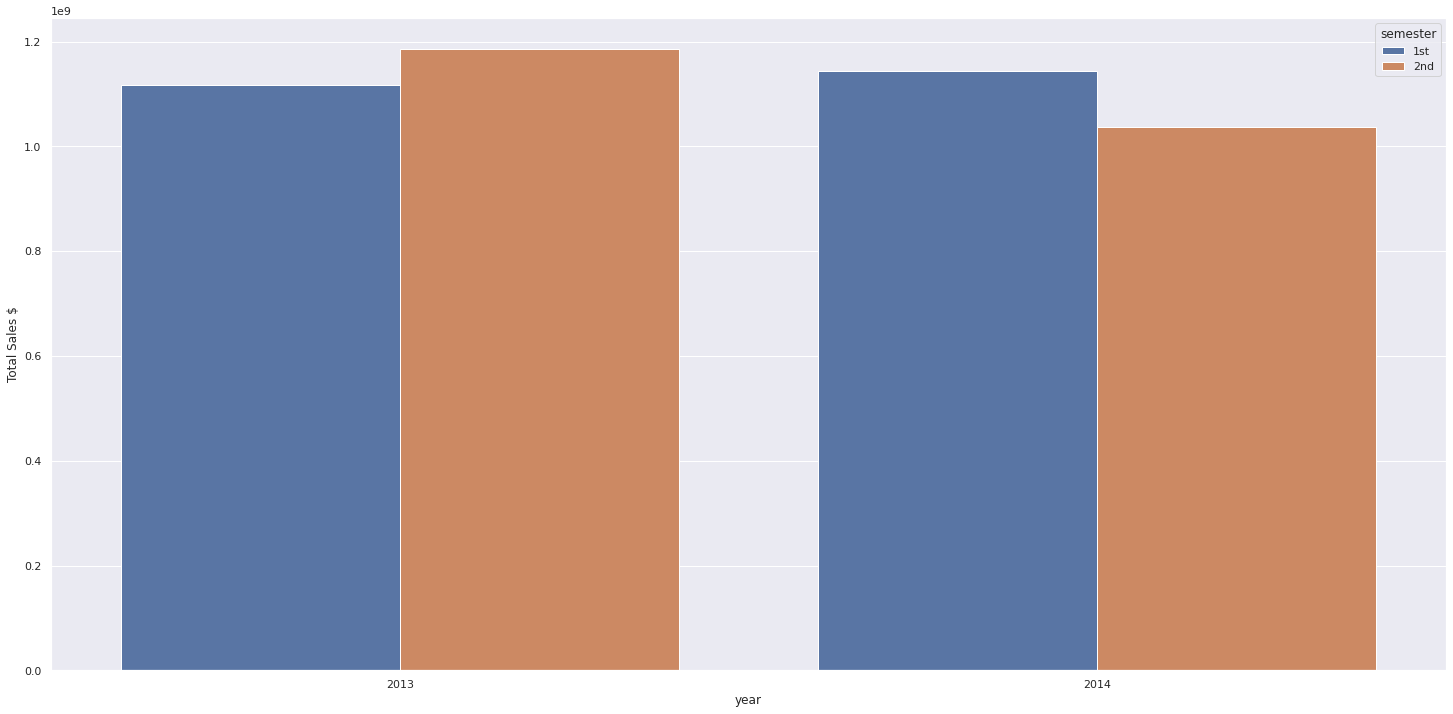

In [ ]:
# Excluding 2015
aux = df4[['year','week','sales']].loc[ df4['year'] != 2015 ].groupby(['year','week']).sum().reset_index()
#spliting into 1st and 2nd semester
aux['semester'] = aux['week'].apply( lambda x: '1st' if x<= 26 else '2nd')
aux2 = aux.groupby( ['year', 'semester'] ).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'semester', data = aux2);
plt.ylabel( 'Total Sales $');

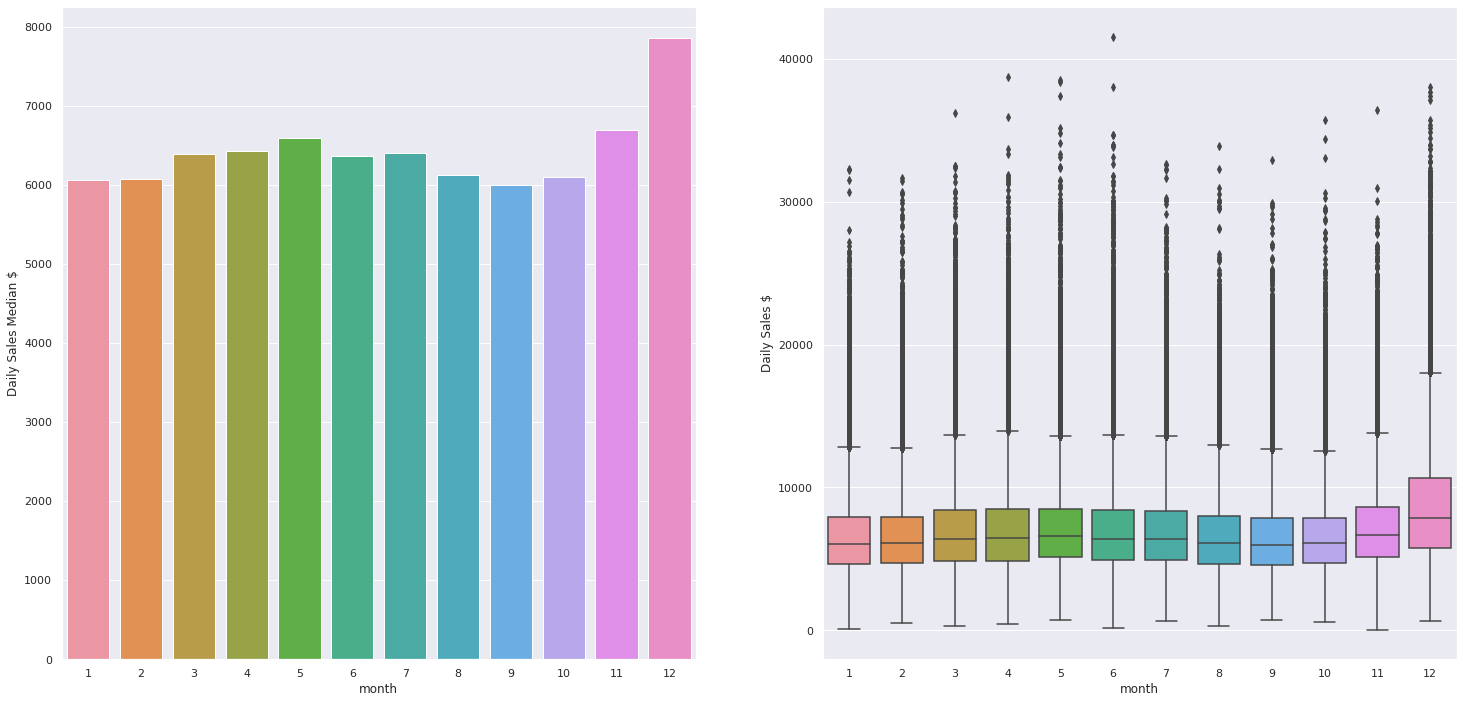

In [ ]:
plt.subplot(1,2,1)
aux1 = df4[['month','sales']].groupby('month').median().reset_index()
sns.barplot(x='month', y='sales', data=aux1)
plt.ylabel( 'Daily Sales Median $')

plt.subplot(1,2,2)
aux2 = df4[['month','sales']] 
sns.boxplot(x='month', y='sales', data=aux2);
plt.ylabel( 'Daily Sales $');

In [ ]:
aux = df4[['year','week','sales']].loc[ df4['year'] == 2013 ].groupby(['year','week']).sum().reset_index()
aux1 = aux.loc[ aux['week'] < 26 ]
s1 = aux1['sales'].sum()
aux2 = aux.loc[ aux['week'] > 26 ]
s2 = aux2['sales'].sum()
aux2 = df4[['year','week','sales']].loc[ df4['year'] == 2014 ].groupby(['year','week']).sum().reset_index()
aux1 = aux.loc[ aux['week'] < 26 ]
s1 = aux1['sales'].sum()
aux2 = aux.loc[ aux['week'] > 26 ]
s2 = aux2['sales'].sum()


print(a)
print(b)
#sns.barplot( x = 'week', y = 'sales', data = aux1 )

2183937646
2222035523


### **H10.** Stores less on weekends
**TRUE** Total sales are lower on weekends.

**Important insight:** Sunday has the highest variations in sales, including the highest 4th quartile ($12k).

It may be feaseble to open stores on sunday (should discuss with business team)

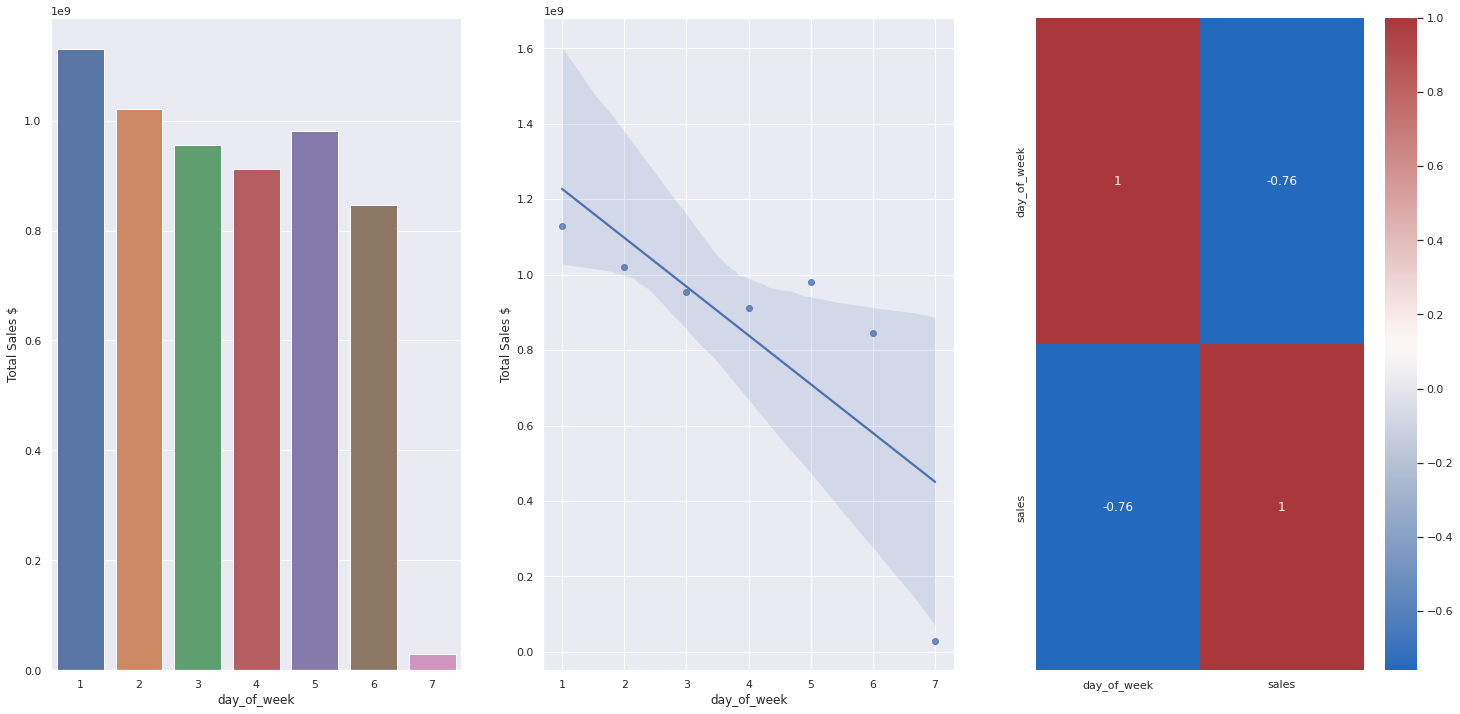

In [ ]:
aux = df4[['sales','day_of_week']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux)
plt.ylabel('Total Sales $')

plt.subplot(1, 3, 2)
sns.regplot( x = 'day_of_week', y = 'sales', data = aux)
plt.ylabel('Total Sales $')

plt.subplot(1, 3, 3)
sns.heatmap( aux.corr( method = 'pearson') , annot = True, cmap = 'vlag');


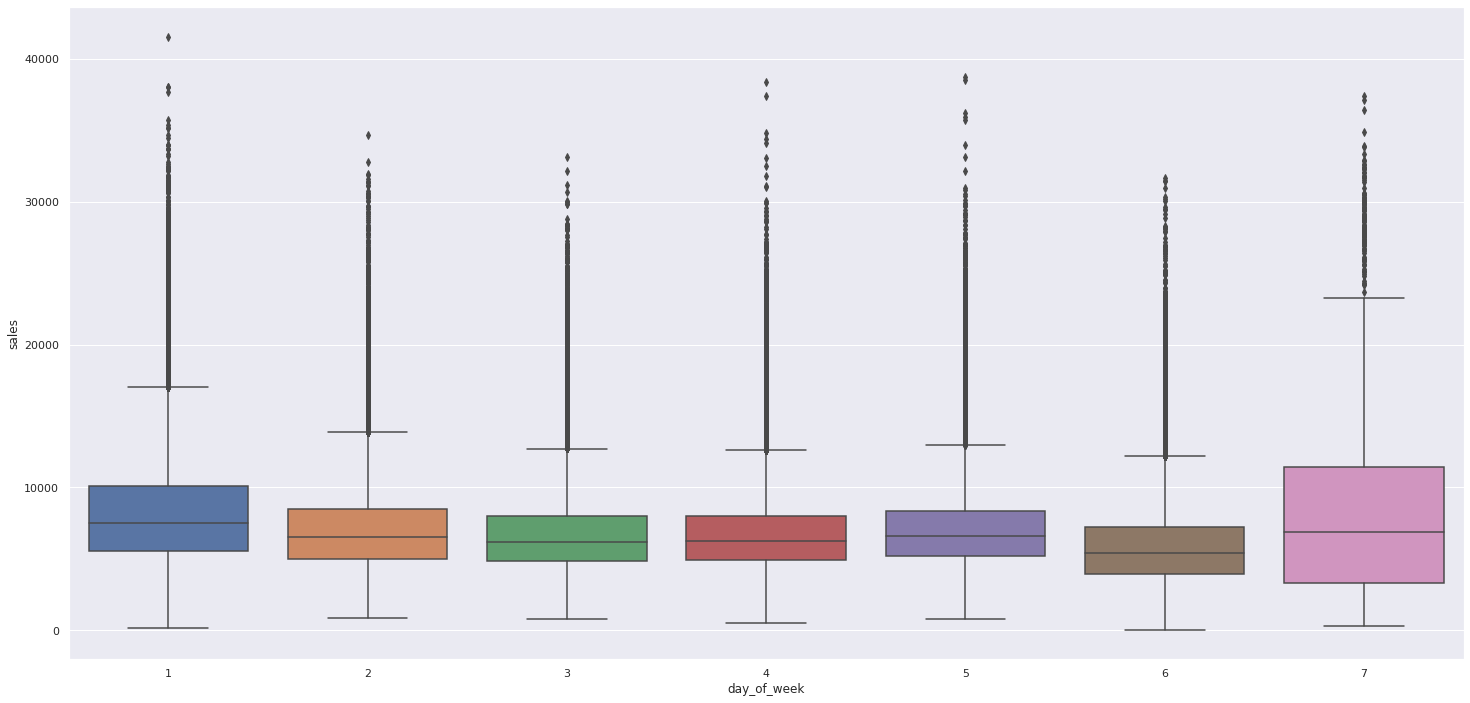

In [ ]:
aux = df4[['sales','day_of_week']] #.groupby('day_of_week').sum().reset_index()
sns.boxplot(x = 'day_of_week', y = 'sales', data = aux);

In [ ]:
aux = df4[['sales','day_of_week']].loc[ df4['year']==2014 ].groupby('day_of_week').sum().reset_index()

print('Total sales for each day in 2014')
aux = aux.style.format( {"sales" : "{:,.2f}"} )
display( aux )
# print('\nNumber of days where stores were open')
# aux2 = df4[['sales','day_of_week']].groupby('day_of_week').count().reset_index()
# print(aux2)
print('\n Possible increase from 11M to 310M')

Total sales for each day in 2014


,day_of_week,sales
0,1,"421,902,297.00"
1,2,"385,086,977.00"
2,3,"357,302,036.00"
3,4,"334,780,996.00"
4,5,"359,487,036.00"
5,6,"310,593,431.00"
6,7,"11,652,123.00"



 Possible increase from 11M to 310M


### **H11.** Stores sell less during school holidays
**FALSE** There is no noticeable difference between average sales on school holidays and regular days.

The difference in total sales is only due to 80% regular days versus 20% school holidays

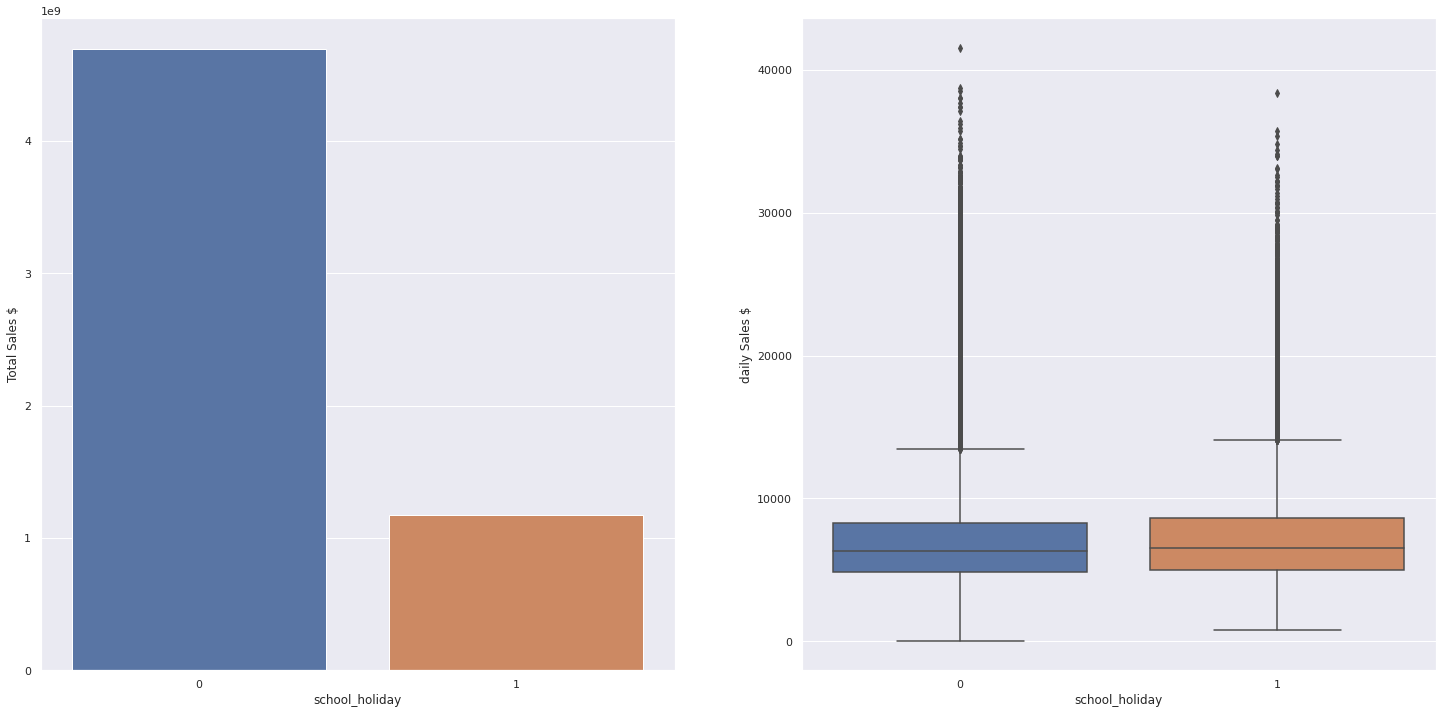

In [ ]:
plt.subplot(1, 2, 1)
aux1 = df4[['school_holiday','sales']].copy().groupby('school_holiday').sum().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1 );
plt.ylabel('Total Sales $')

plt.subplot(1, 2, 2)
aux2 = df4[['school_holiday','sales']].copy() #.groupby('school_holiday').median().reset_index()
sns.boxplot(  x = 'school_holiday', y = 'sales', data = aux2  );
plt.ylabel('daily Sales $');


In [ ]:
df4['school_holiday'].value_counts()/len( df4['school_holiday'] )

0    0.806422
1    0.193578
Name: school_holiday, dtype: float64

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

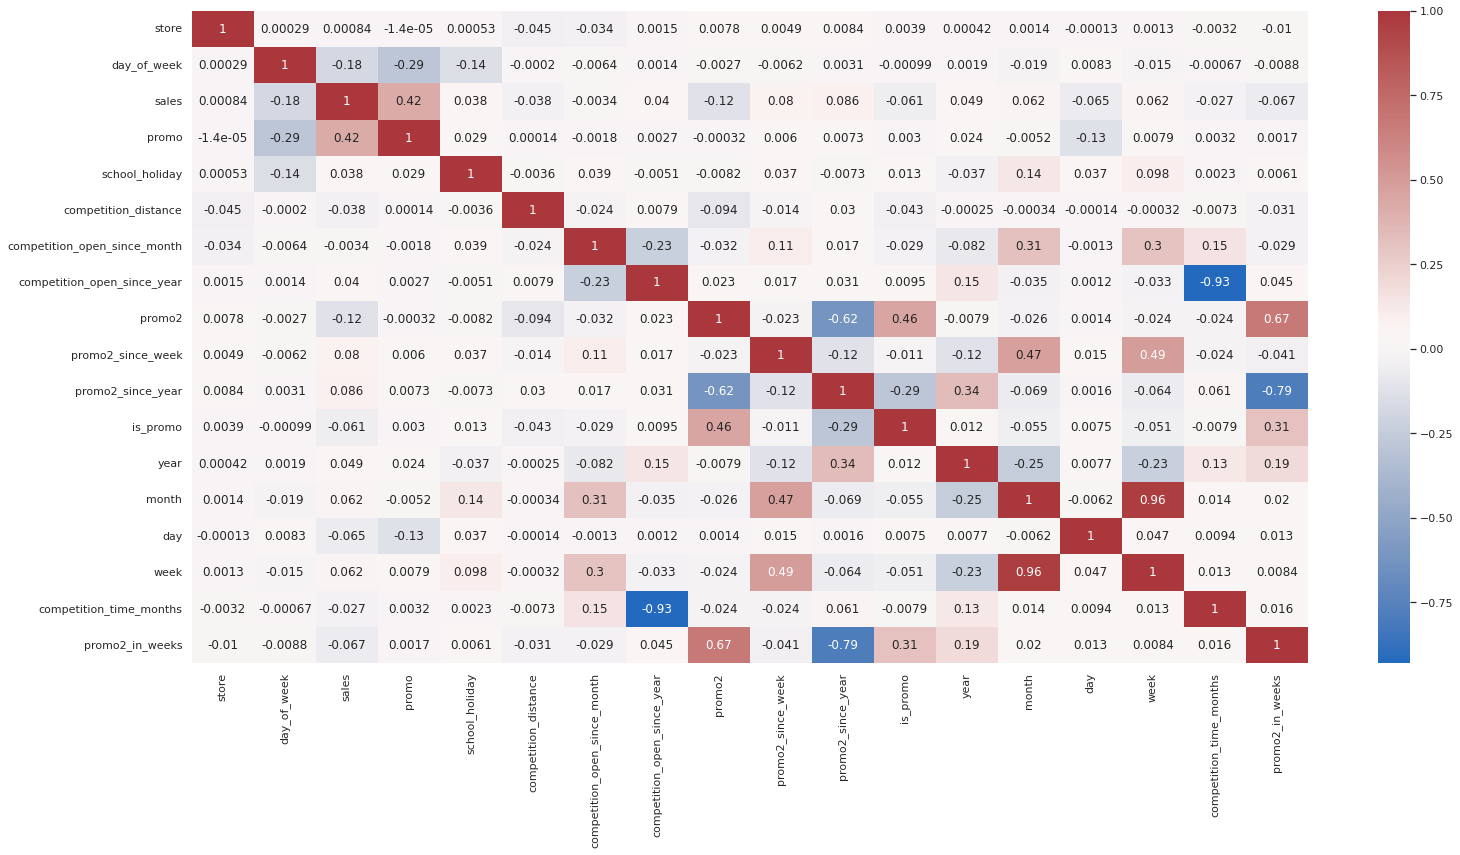

In [ ]:
# Spearman Correlation
num_att = df4.select_dtypes( include=['int','float'])
correlation = num_att.corr( method = 'spearman')
sns.heatmap( correlation, annot = True, cmap = 'vlag');

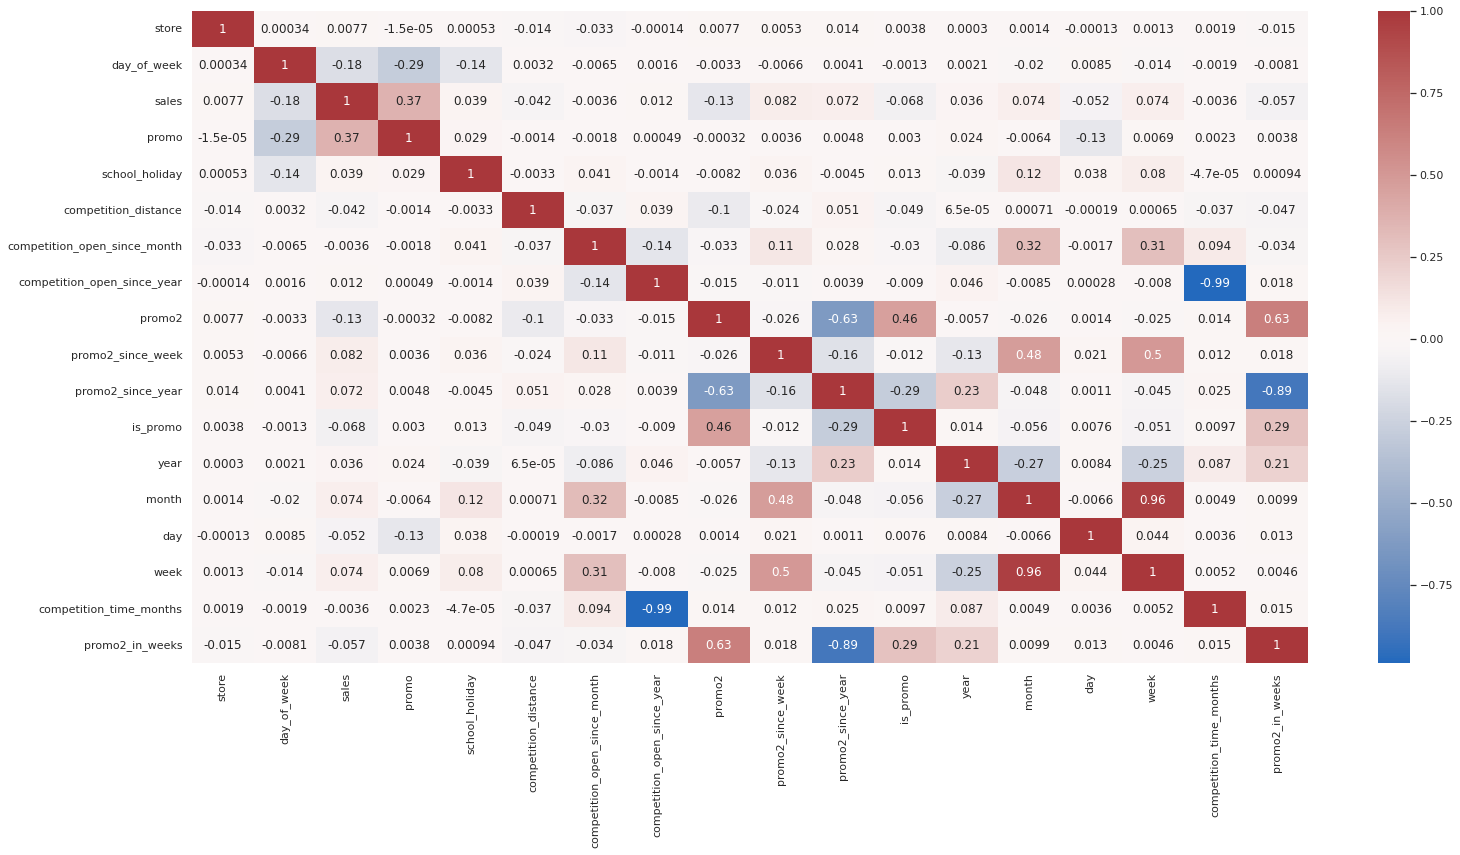

In [ ]:
# Pearson Correlation
correlation = num_att.corr( method = 'pearson')
sns.heatmap( correlation, annot = True, cmap = 'vlag');


### 4.3.2 Categorical Attributes

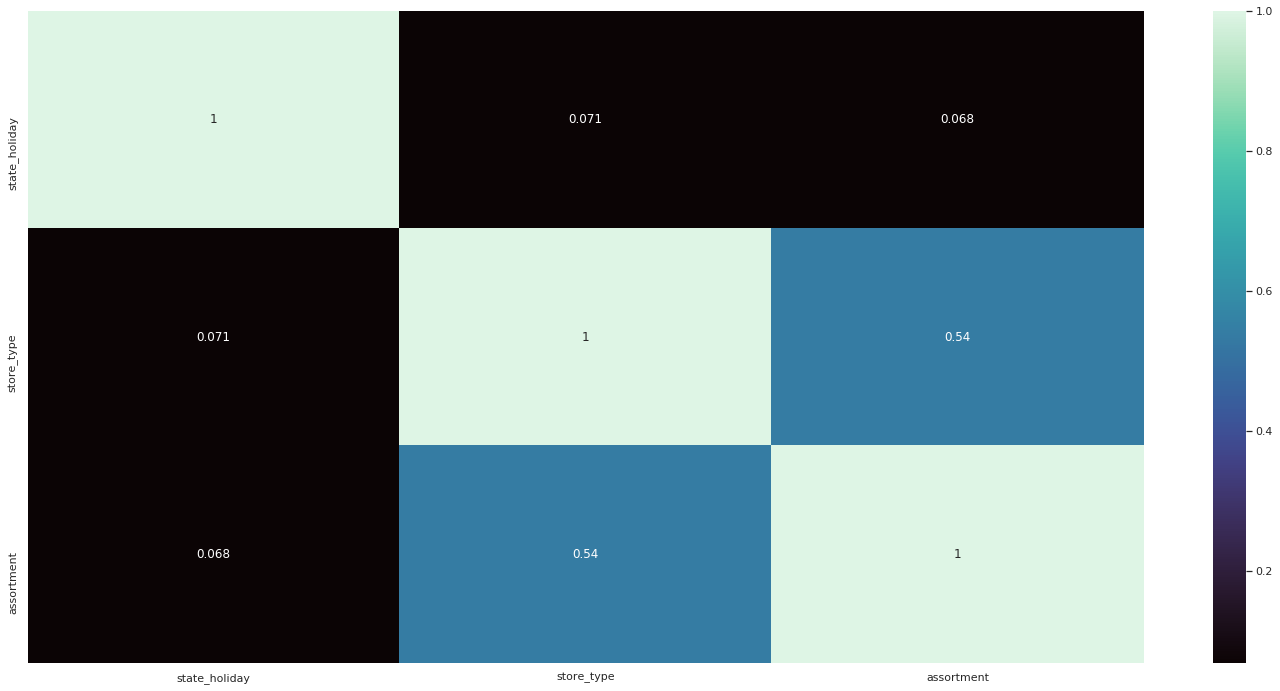

In [ ]:
cat_att = df4.select_dtypes( exclude = ['int', 'float', 'datetime']).copy()
cat_att.drop(['year_week','competition_since', 'date'], axis = 1, inplace = True )
cramer_v( cat_att )
sns.heatmap(a, annot = True, cmap="mako");

# 5.0 Data Preparation

In [5]:
# data loading
df5 = df4.copy()
#df5 = pd.read_csv('./df3.csv', low_memory = False, parse_dates = ['date', 'competition_since'] )

In [6]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week,year_week,competition_since,competition_time_months,promo2_in_weeks
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,0


In [7]:
# train test split leaving last 6 weeks of data as test. X_train_full and X_test_full contain all columns.
X_train, X_test, y_train, y_test, X_train_full, X_test_full = train_test_split( df5 )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 5.1 Numerical Variables Preparation

### 5.1.1 Rescaling

In [68]:
num_att = X_train_full.select_dtypes( include = ['int','float'] )
num_att.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week,competition_time_months,promo2_in_weeks
41396,1,4,4645,1,0,1270.0,9,2008,0,25,2015,0,2015,6,18,25,82,0
41397,2,4,5154,1,0,570.0,11,2007,1,13,2010,0,2015,6,18,25,92,273
41398,3,4,7537,1,0,14130.0,12,2006,1,14,2011,0,2015,6,18,25,104,220
41399,4,4,8880,1,0,620.0,9,2009,0,25,2015,0,2015,6,18,25,70,0
41400,5,4,4924,1,0,29910.0,4,2015,0,25,2015,0,2015,6,18,25,2,0


In [8]:
rs_competition_distance = RobustScaler()
rs_competition_months =   RobustScaler()
mme_promo2_in_weeks =     MinMaxScaler()
mme_year =                MinMaxScaler()

#competition_distance - has outliers: using robust scaler
X_train_full['competition_distance'] = rs_competition_distance.fit_transform(X_train_full[['competition_distance']].values )
X_test_full['competition_distance'] = rs_competition_distance.transform(X_test_full[['competition_distance']].values)
pickle.dump( rs_competition_distance, open( '../parameters/scaler_competition_distance.pkl', 'wb' ) )

#competition_time_months - has outliers: using robust scaler
X_train_full['competition_time_months'] = rs_competition_months.fit_transform(X_train_full[['competition_time_months']].values )
X_test_full['competition_time_months'] = rs_competition_months.transform(X_test_full[['competition_time_months']].values )
pickle.dump( rs_competition_months, open( '../parameters/scaler_competition_time_months.pkl', 'wb' ) )

#promo2_in_weeks - has no outliers: using minmax scaler
X_train_full['promo2_in_weeks'] = mme_promo2_in_weeks.fit_transform(X_train_full[['promo2_in_weeks']].values )
X_test_full['promo2_in_weeks'] = mme_promo2_in_weeks.transform(X_test_full[['promo2_in_weeks']].values )
pickle.dump( mme_promo2_in_weeks, open( '../parameters/scaler_promo2_in_weeks.pkl', 'wb' ) )

#year - has no outliers: using minmax scaler
X_train_full['year'] = mme_year.fit_transform(X_train_full[['year']].values )
X_test_full['year'] = mme_year.transform(X_test_full[['year']].values )
pickle.dump( mme_year, open( '../parameters/scaler_year.pkl', 'wb' ) )

#response variable - aplying log(1+x) transform
X_train_full['sales'] = np.log1p( X_train_full['sales'] )
X_test_full['sales'] = np.log1p( X_test_full['sales'] )


/home/humberto/anaconda3/envs/ross2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/humberto/anaconda3/envs/ross2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## 5.2.0 Categorical Data Encoding

In [75]:
cat_att = X_train_full.select_dtypes( exclude = ['int', 'float'] )
cat_att.head()

,date,state_holiday,store_type,assortment,year_week,competition_since
41396,2015-06-18,regular_day,c,basic,2015-24,2008-09-01
41397,2015-06-18,regular_day,a,basic,2015-24,2007-11-01
41398,2015-06-18,regular_day,a,basic,2015-24,2006-12-01
41399,2015-06-18,regular_day,c,extended,2015-24,2009-09-01
41400,2015-06-18,regular_day,a,basic,2015-24,2015-04-01


In [9]:
# state holiday
X_train_full = pd.get_dummies( X_train_full, prefix = ['state_holiday'], columns = ['state_holiday'] )
X_test_full = pd.get_dummies( X_test_full, prefix = ['state_holiday'], columns = ['state_holiday'] )

# store_type
le_store_type = LabelEncoder()
X_train_full['store_type'] = le_store_type.fit_transform(X_train_full[['store_type']].values )
X_test_full['store_type'] = le_store_type.fit_transform(X_test_full[['store_type']].values )
pickle.dump( le_store_type, open('../parameters/encoder_store_type.pkl', 'wb' ) )

# assortment
assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
X_train_full['assortment'] = X_train_full['assortment'].map( assortment_dict )
X_test_full['assortment'] = X_test_full['assortment'].map( assortment_dict )


/home/humberto/anaconda3/envs/ross2/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 5.3 Cyclical Transformation

In [10]:
# month
X_train_full['month_sin'] = X_train_full['month'].apply( lambda x: np.sin( (2.0*np.pi*x)/12.0 ) )
X_train_full['month_cos'] = X_train_full['month'].apply( lambda x: np.cos( (2.0*np.pi*x)/12.0 ) )
X_test_full['month_sin'] = X_test_full['month'].apply( lambda x: np.sin( (2.0*np.pi*x)/12.0 ) )
X_test_full['month_cos'] = X_test_full['month'].apply( lambda x: np.cos( (2.0*np.pi*x)/12.0 ) )

# week
X_train_full['week_sin'] = X_train_full['week'].apply( lambda x: np.sin( (2.0*np.pi*x)/52 ) )
X_train_full['week_cos'] = X_train_full['week'].apply( lambda x: np.cos( (2.0*np.pi*x)/52 ) )
X_test_full['week_sin'] = X_test_full['week'].apply( lambda x: np.sin( (2.0*np.pi*x)/52 ) )
X_test_full['week_cos'] = X_test_full['week'].apply( lambda x: np.cos( (2.0*np.pi*x)/52 ) )

# day
X_train_full['day_sin'] = X_train_full['day'].apply( lambda x: np.sin( (2.0*np.pi*x)/31 ) )
X_train_full['day_cos'] = X_train_full['day'].apply( lambda x: np.cos( (2.0*np.pi*x)/31 ) )
X_test_full['day_sin'] = X_test_full['day'].apply( lambda x: np.sin( (2.0*np.pi*x)/31 ) )
X_test_full['day_cos'] = X_test_full['day'].apply( lambda x: np.cos( (2.0*np.pi*x)/31 ) )

# day of week sin
X_train_full['day_of_week_sin'] = X_train_full['day_of_week'].apply( lambda x: np.sin( (2.0*np.pi*x)/7.0 ) )
X_train_full['day_of_week_cos'] = X_train_full['day_of_week'].apply( lambda x: np.cos( (2.0*np.pi*x)/7.0 ) )
X_test_full['day_of_week_sin'] = X_test_full['day_of_week'].apply( lambda x: np.sin( (2.0*np.pi*x)/7.0 ) )
X_test_full['day_of_week_cos'] = X_test_full['day_of_week'].apply( lambda x: np.cos( (2.0*np.pi*x)/7.0 ) )

In [11]:
df5 = pd.concat( [X_train_full, X_test_full], axis = 0)
df5.fillna(0, inplace = True) # X_test_full has no holiday and therefore came with NA
df5.to_csv('./df5.csv', index = False)

# 6.0 Feature Selection

In [93]:
df6 = df5.copy()
#df6 = pd.read_csv( './df5.csv', low_memory= False)
#df6.head()

In [ ]:
# removing columns that were transformed using sin(x) and cos(x)
cols_drop = [ 'month', 'week', 'day', 'day_of_week', 'competition_since', 'year_week' ]
df6.drop(labels = cols_drop, axis = 1, inplace = True)

## 6.1 Spliting Dataframe into Train Test 

In [94]:
X_train, X_test, y_train, y_test, X_train_full, X_test_full = train_test_split( df6 ) # X_test = 6 last weeks of data

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta Feature Selection

In [ ]:
# train test datasets for boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis = 1 ).values
# y_train_n = y_train.values


rf = RandomForestRegressor( n_jobs = -1)
boruta = BorutaPy( rf, n_estimators='auto', verbose = 2, random_state =  42).fit( X_train, y_train )
# took about 1:30 hrs to run

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


## 6.3 Results and Considerations

In [ ]:
#cols_selected = boruta.support_.tolist()
cols_sel = [True, True, False, True, True, True, True, True, True, True, True, False, False, True, True, False, False, False, False, False, True, False, False, True, True, True, True]
cols_selected = X_train.drop( ['date', 'sales'], axis = 1 ).iloc[ : , cols_sel].columns.tolist()

cols_unselected = [ not element for element in cols_sel]
cols_unselected = X_train.drop(['sales', 'date'], axis = 1).iloc[:, cols_unselected ].columns.tolist()
cols_selected

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_months',
 'promo2_in_weeks',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [ ]:
# cols_unselected:

#  Column                               Include?
#  'school_holiday',                    NO
#  'is_promo',                          NO
#  'year',                              NO
#  'state_holiday_christmas',           NOT NOW (Maybe in a nex cycle)
#  'state_holiday_easter_holiday',      NOT NOW (Maybe in a nex cycle)    
#  'state_holiday_public_holiday',      NOT NOW (Maybe in a nex cycle)
#  'state_holiday_regular_day',         NOT NOW (Maybe in a nex cycle)
#  'month_sin',                         YES
#  'week_sin',                          YES 
#  'week_cos'                           YES    